#### Project Name:  
Neuefische Capstone Project: 'DIE ZEIT' Churn Prediction  
    
#### Description :  
The task of this data science project is it to perform a churn prediction based on the cancellations of previous years. So, basically answering the question 'Which customer is canceling his or her subscription within the next year?'. To answer this question a model should get trained with the data from previous years (after 2012) to predict the affinity of canceling per order.
This notebook contains the exploratory data analysis to gather initial information about the processed data set and preprocess the data for the next step of modeling.
The the target variable is churn.  

#### Team :  
Kevin Tomas 
Sebastian Rötten  
Chandrakantha Hassan Anantharajaiah  
Michael Leder  
Time Period  

*Project Start: 23/11/2020*  
*Project End: 18/12/2020*

#### Environment and Libraries setup

In [1]:
# importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="white")
plt.style.use('ggplot')
%matplotlib inline

# importing Feature selection module
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs

# warnings handler
import warnings
warnings.filterwarnings("ignore")

# Display Options for pandas
pd.set_option('display.max_columns', None)   # Displays all columns in the table
pd.set_option('display.max_rows', None)      # Displays all rows

#### Reading the data and exploring basic information

In [2]:
df = pd.read_csv('00_data/clean_wo_outliers.csv')

In [3]:
df.head()

,Unnamed: 0,liefer_beginn_evt,kanal,objekt_name,aboform_name,zahlung_rhythmus_name,lesedauer,rechnungsmonat,zahlung_weg_name,studentenabo,plz_1,plz_2,plz_3,ort,metropole,land_iso_code,shop_kauf,unterbrechung,anrede,titel,avg_churn,email_am_kunden,zon_che_opt_in,zon_sit_opt_in,zon_zp_grey,zon_premium,zon_boa,zon_kommentar,zon_sonstige,zon_zp_red,zon_rawr,zon_community,zon_app_sonstige,zon_schach,zon_blog_kommentare,zon_quiz,cnt_abo,cnt_abo_diezeit,cnt_abo_diezeit_digital,cnt_abo_magazin,cnt_umwandlungsstatus2_dkey,abo_registrierung_min,nl_zeitbrief,nl_zeitshop,nl_zeitverlag_hamburg,nl_fdz_organisch,nl_blacklist_sum,nl_bounced_sum,nl_aktivitaet,nl_registrierung_min,nl_sperrliste_sum,nl_opt_in_sum,boa_reg,che_reg,sit_reg,sso_reg,received_anzahl_1w,received_anzahl_1m,received_anzahl_3m,received_anzahl_6m,opened_anzahl_1w,opened_anzahl_1m,opened_anzahl_3m,openedanzahl_6m,clicked_anzahl_1w,clicked_anzahl_1m,clicked_anzahl_3m,clicked_anzahl_6m,unsubscribed_anzahl_1w,unsubscribed_anzahl_1m,unsubscribed_anzahl_3m,unsubscribed_anzahl_6m,openrate_1w,clickrate_1w,openrate_1m,clickrate_1m,openrate_3m,clickrate_3m,received_anzahl_bestandskunden_1w,received_anzahl_bestandskunden_1m,received_anzahl_bestandskunden_3m,received_anzahl_bestandskunden_6m,opened_anzahl_bestandskunden_1w,opened_anzahl_bestandskunden_1m,opened_anzahl_bestandskunden_3m,openedanzahl_bestandskunden_6m,clicked_anzahl_bestandskunden_1w,clicked_anzahl_bestandskunden_1m,clicked_anzahl_bestandskunden_3m,clicked_anzahl_bestandskunden_6m,unsubscribed_anzahl_bestandskunden_1w,unsubscribed_anzahl_bestandskunden_1m,unsubscribed_anzahl_bestandskunden_3m,unsubscribed_anzahl_bestandskunden_6m,openrate_bestandskunden_1w,clickrate_bestandskunden_1w,openrate_bestandskunden_1m,clickrate_bestandskunden_1m,openrate_bestandskunden_3m,clickrate_bestandskunden_3m,received_anzahl_produktnews_1w,received_anzahl_produktnews_1m,received_anzahl_produktnews_3m,received_anzahl_produktnews_6m,opened_anzahl_produktnews_1w,opened_anzahl_produktnews_1m,opened_anzahl_produktnews_3m,openedanzahl_produktnews_6m,clicked_anzahl_produktnews_1w,clicked_anzahl_produktnews_1m,clicked_anzahl_produktnews_3m,clicked_anzahl_produktnews_6m,unsubscribed_anzahl_produktnews_1w,unsubscribed_anzahl_produktnews_1m,unsubscribed_anzahl_produktnews_3m,unsubscribed_anzahl_produktnews_6m,openrate_produktnews_1w,clickrate_produktnews_1w,openrate_produktnews_1m,clickrate_produktnews_1m,openrate_produktnews_3m,clickrate_produktnews_3m,received_anzahl_hamburg_1w,received_anzahl_hamburg_1m,received_anzahl_hamburg_3m,received_anzahl_hamburg_6m,opened_anzahl_hamburg_1w,opened_anzahl_hamburg_1m,opened_anzahl_hamburg_3m,openedanzahl_hamburg_6m,clicked_anzahl_hamburg_1w,clicked_anzahl_hamburg_1m,clicked_anzahl_hamburg_3m,clicked_anzahl_hamburg_6m,unsubscribed_anzahl_hamburg_1w,unsubscribed_anzahl_hamburg_1m,unsubscribed_anzahl_hamburg_3m,unsubscribed_anzahl_hamburg_6m,openrate_hamburg_1w,clickrate_hamburg_1w,openrate_hamburg_1m,clickrate_hamburg_1m,openrate_hamburg_3m,clickrate_hamburg_3m,received_anzahl_zeitbrief_1w,received_anzahl_zeitbrief_1m,received_anzahl_zeitbrief_3m,received_anzahl_zeitbrief_6m,opened_anzahl_zeitbrief_1w,opened_anzahl_zeitbrief_1m,opened_anzahl_zeitbrief_3m,openedanzahl_zeitbrief_6m,clicked_anzahl_zeitbrief_1w,clicked_anzahl_zeitbrief_1m,clicked_anzahl_zeitbrief_3m,clicked_anzahl_zeitbrief_6m,unsubscribed_anzahl_zeitbrief_1w,unsubscribed_anzahl_zeitbrief_1m,unsubscribed_anzahl_zeitbrief_3m,unsubscribed_anzahl_zeitbrief_6m,openrate_zeitbrief_1w,clickrate_zeitbrief_1w,openrate_zeitbrief_1m,clickrate_zeitbrief_1m,openrate_zeitbrief_3m,clickrate_zeitbrief_3m,training_set,kuendigungs_eingangs_datum,churn,date_x
0,0,2013-10-02,andere,ZEIT Digital,Probeabo,jährlich,68,0,Bankeinzug,0,6,64,647,Erbach,0,DE,4,0,Frau,akademischer Titel,0.133879,1.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4,2,0,2,2,2005-01-27 07:53:59,2,2,0,0,0,1,14,2005-09-30 00:00:00,0,0,0,0,0,1,6,14,43,80,4,15,38,74,1,2,2,2,0,0,0,0,0.67,0.25,1.07,0.13,0.88,0.05,0,0,0

In [4]:
# dropping the unwanted column
df.drop(["Unnamed: 0"], axis=1, inplace=True)

# checking for the dimension of the dataset
df.shape

(156982, 169)

0    0.692563
1    0.307437
Name: churn, dtype: float64

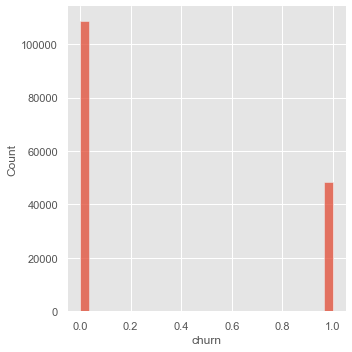

In [7]:
# checking for data target dats distribution
sns.displot(df, x='churn')
df['churn'].value_counts(1)

we see from above distribution that our target variable is unevenly distributed  
churn = 1 is 69 %  
churn = 0 is 31 %

#### Defining functions for recurrent use in EDA

In [9]:
# Function to calculate missing values by column
def missing_values_table(df):
        # Total missing values
        mis_val = df.isnull().sum()
        
        # Percentage of missing values
        mis_val_percent = 100 * mis_val / len(df)
        
        # Make a table with the results
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
        
        # Rename the columns
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Values'})
        
        # Sort the table by percentage of missing descending
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(3)
        
        # Print some summary information
        print ("The selected dataframe has " + str(df.shape[1]) + " columns.\n"      
            "There are " + str(mis_val_table_ren_columns.shape[0]) +
              " columns that have missing values.")
        
        # Return the dataframe with missing information
        return mis_val_table_ren_columns

In [10]:
# Function for finding descripencies in dataset
def meta(df, transpose=True):
    """
    This function returns a dataframe that lists:
    - column names
    - nulls abs
    - nulls rel
    - dtype
    - duplicates
    - number of diffrent values (nunique)
    """
    metadata = []
    dublicates = sum([])
    for elem in df.columns:

        # Counting null values and percantage
        null = df[elem].isnull().sum()
        rel_null = round(null/df.shape[0]*100, 2)

        # Defining the data type
        dtype = df[elem].dtype

        # Check dublicates
        duplicates = df[elem].duplicated().any()

        # Check number of nunique vales
        nuniques = df[elem].nunique()


        # Creating a Dict that contains all the metadata for the variable
        elem_dict = {
            'varname': elem,
            'nulls': null,
            'percent': rel_null,
            'dtype': dtype,
            'dup': duplicates,
            'nuniques': nuniques
        }
        metadata.append(elem_dict)

    meta = pd.DataFrame(metadata, columns=['varname', 'nulls', 'percent', 'dtype', 'dup', 'nuniques'])
    meta.set_index('varname', inplace=True)
    meta = meta.sort_values(by=['nulls'], ascending=False)
    if transpose:
        return meta.transpose()
    print(f"Shape: {df.shape}")

    return meta

In [11]:
# Correlation diagram
def correlation(df):
    """
    This function plots a correlogram.
    """
    #Plot
    fig, ax = plt.subplots(figsize=(18, 14))
    mask = np.triu(df.corr())
    ax = sns.heatmap(round(df.corr()*100, 0),
                     annot=True,
                     mask=mask, cmap="coolwarm")
    return df.corr().round(2)

In [90]:
# Defining a fucntion for plotting categorical variable and rate of churn
def plot_categorical_variables_bar(data, column_name, rotation = 0, horizontal_adjust = 0, figsize = (15,6), percentage_display = True, plot_defaulter = True,
                                   fontsize_percent = 'xx-small', ha='centre'):
    
    '''
    Function to plot Categorical Variables Bar Plots
    
    Inputs:
        data: DataFrame
            The DataFrame from which to plot
        column_name: str
            Column's name whose distribution is to be plotted
        figsize: tuple, default = (18,6)
            Size of the figure to be plotted
        percentage_display: bool, default = True
            Whether to display the percentages on top of Bars in Bar-Plot
        plot_defaulter: bool
            Whether to plot the Bar Plots for Defaulters or not
        rotation: int, default = 0
            Degree of rotation for x-tick labels
        horizontal_adjust: int, default = 0
            Horizontal adjustment parameter for percentages displayed on the top of Bars of Bar-Plot
        fontsize_percent: str, default = 'xx-small'
            Fontsize for percentage Display
        
    '''
    print(f"Total Number of unique categories of {column_name} = {len(data[column_name].unique())}")
    
    plt.figure(figsize = figsize, tight_layout = True)
    sns.set(style = 'whitegrid', font_scale = 1.2)
    
    #plotting overall distribution of category
    plt.subplot(1,2,1)
    data_to_plot = data[column_name].value_counts().sort_values(ascending = False)
    ax = sns.barplot(x = data_to_plot.index, y = data_to_plot, palette = 'Set1')
    
    if percentage_display:
        total_datapoints = len(data[column_name].dropna())
        for p in ax.patches:
            ax.text(p.get_x() + horizontal_adjust, p.get_height() + 0.005 * total_datapoints, '{:1.02f}%'.format(p.get_height() * 100 / total_datapoints), fontsize = fontsize_percent)
        
    plt.xlabel(column_name, labelpad = 7.5)
    plt.title(f'Distribution of {column_name}', pad = 10)
    plt.xticks(rotation = rotation)
    plt.ylabel('Counts')
    
    #plotting distribution of category for churn
    if plot_defaulter:
        percentage_defaulter_per_category = (data[column_name][data.churn == 1].value_counts() * 100 / data[column_name].value_counts()).dropna().sort_values(ascending = False)

        plt.subplot(1,2,2)
        sns.barplot(x = percentage_defaulter_per_category.index, y = percentage_defaulter_per_category, palette = 'Set2')
        plt.ylabel('Percentage of churner per category')
        plt.xlabel(column_name, labelpad = 7.5)
        plt.xticks(rotation = rotation)
        plt.title(f'Percentage of churner for each category of {column_name}', pad = 10)
    plt.show()
    print()
    print()
    print("*"*100)

In [13]:
# Defining a function for numerical feature with options for different plots
def plot_numerical_variables(data, column_name, plots = ['distplot', 'CDF', 'box', 'violin', 'bar','count'],
                             scale_limits = None, figsize = (12,6), 
                              histogram = True, log_scale = False):
    
    '''
    Function to plot continuous variables distribution
    
    Inputs:
        data: DataFrame
            The DataFrame from which to plot.
        column_name: str
            Column's name whose distribution is to be plotted.
        plots: list, default = ['distplot', 'CDF', box', 'violin']
            List of plots to plot for Continuous Variable.
        scale_limits: tuple (left, right), default = None
            To control the limits of values to be plotted in case of outliers.
        figsize: tuple, default = (20,8)
            Size of the figure to be plotted.
        histogram: bool, default = True
            Whether to plot histogram along with distplot or not.
        log_scale: bool, default = False
            Whether to use log-scale for variables with outlying points.
    '''
    data_to_plot = data.copy()
    if scale_limits:
        #taking only the data within the specified limits
        data_to_plot[column_name] = data[column_name][(data[column_name] > scale_limits[0]) & (data[column_name] < scale_limits[1])]

    number_of_subplots = len(plots)
    plt.figure(figsize = figsize)
    sns.set_style('whitegrid')
    
    for i, ele in enumerate(plots):
        plt.subplot(1, number_of_subplots, i + 1)
        plt.subplots_adjust(wspace=0.25)
        
        if ele == 'CDF':
            #making the percentile DataFrame for both positive and negative Class Labels
            percentile_values_0 = data_to_plot[data_to_plot.churn == 0][[column_name]].dropna().sort_values(by = column_name)
            percentile_values_0['Percentile'] = [ele / (len(percentile_values_0)-1) for ele in range(len(percentile_values_0))]
            
            percentile_values_1 = data_to_plot[data_to_plot.churn == 1][[column_name]].dropna().sort_values(by = column_name)
            percentile_values_1['Percentile'] = [ele / (len(percentile_values_1)-1) for ele in range(len(percentile_values_1))]
            
            plt.plot(percentile_values_0[column_name], percentile_values_0['Percentile'], color = 'darkorange', label = 'Non-churner')
            plt.plot(percentile_values_1[column_name], percentile_values_1['Percentile'], color = 'seagreen', label = 'churner')
            plt.xlabel(column_name)
            plt.ylabel('Probability')
            plt.title('CDF of {}'.format(column_name))
            plt.legend(fontsize = 'medium')
            if log_scale:
                plt.xscale('log')
                plt.xlabel(column_name + ' - (log-scale)')
        
        if ele == 'distplot':  
            sns.distplot(data_to_plot[column_name][data['churn'] == 0].dropna(),
                         label='Non-churner', hist = False, color='darkorange')
            sns.distplot(data_to_plot[column_name][data['churn'] == 1].dropna(),
                         label='churner', hist = False, color='seagreen')
            plt.xlabel(column_name)
            plt.ylabel('Probability Density')
            plt.legend(fontsize='medium')
            plt.title("Dist-Plot of {}".format(column_name))
            if log_scale:
                plt.xscale('log')
                plt.xlabel(f'{column_name} (log scale)')

        if ele == 'violin':  
            sns.violinplot(x='churn', y=column_name, data=data_to_plot)
            plt.title("Violin-Plot of {}".format(column_name))
            if log_scale:
                plt.yscale('log')
                plt.ylabel(f'{column_name} (log Scale)')
                
        if ele == 'bar':  
            sns.barplot(x='churn', y=column_name, data=data_to_plot)
            plt.title("Bar-Plot of {}".format(column_name))
            if log_scale:
                plt.yscale('log')
                plt.ylabel(f'{column_name} (log Scale)')

        if ele == 'box':  
            sns.boxplot(x='churn', y=column_name, data=data_to_plot)
            plt.title("Box-Plot of {}".format(column_name))
            if log_scale:
                plt.yscale('log')
                plt.ylabel(f'{column_name} (log Scale)')
        
        if ele == 'count':  
            sns.countplot(x=column_name, hue='churn', data=data_to_plot)
            plt.title("countplot of {}".format(column_name))
            plt.legend(loc='upper right')
            if log_scale:
                plt.yscale('log')
                plt.ylabel(f'{column_name} (log Scale)')

    plt.show()

#### Divide the dataset into 2 categories with produktnews and Hamburg news letter columns

##### *Produktnews dataset and initial analysis*

In [15]:
# creating productnews dataframe with important variables that could influence the target value

# abonnement status variable
data_abo_status = df[['nl_zeitverlag_hamburg','nl_fdz_organisch', 'nl_blacklist_sum',
                    'nl_bounced_sum','nl_aktivitaet','nl_registrierung_min','nl_sperrliste_sum']]

# Initial 21 columns which contains demographic information
data_demo = df.iloc[:,0:21]

# columns with variables related to produktnews
data_productnews = df.iloc[:,99:121]

# target variable
data_target = df['churn']

# combining all the splits to create new producktnews dataframe
EDA_produktnews = pd.concat([data_demo, data_abo_status, data_productnews, data_target], axis=1)

In [17]:
# overview of new dataframe
EDA_produktnews.head(2)

,liefer_beginn_evt,kanal,objekt_name,aboform_name,zahlung_rhythmus_name,lesedauer,rechnungsmonat,zahlung_weg_name,studentenabo,plz_1,plz_2,plz_3,ort,metropole,land_iso_code,shop_kauf,unterbrechung,anrede,titel,avg_churn,email_am_kunden,nl_zeitverlag_hamburg,nl_fdz_organisch,nl_blacklist_sum,nl_bounced_sum,nl_aktivitaet,nl_registrierung_min,nl_sperrliste_sum,received_anzahl_produktnews_1w,received_anzahl_produktnews_1m,received_anzahl_produktnews_3m,received_anzahl_produktnews_6m,opened_anzahl_produktnews_1w,opened_anzahl_produktnews_1m,opened_anzahl_produktnews_3m,openedanzahl_produktnews_6m,clicked_anzahl_produktnews_1w,clicked_anzahl_produktnews_1m,clicked_anzahl_produktnews_3m,clicked_anzahl_produktnews_6m,unsubscribed_anzahl_produktnews_1w,unsubscribed_anzahl_produktnews_1m,unsubscribed_anzahl_produktnews_3m,unsubscribed_anzahl_produktnews_6m,openrate_produktnews_1w,clickrate_produktnews_1w,openrate_produktnews_1m,clickrate_produktnews_1m,openrate_produktnews_3m,clickrate_produktnews_3m,churn
0,2013-10-02,andere,ZEIT Digital,Probeabo,jährlich,68,0,Bankeinzug,0,6,64,647,Erbach,0,DE,4,0,Frau,akademischer Titel,0.133879,1.0,0,0,0,1,14,2005-09-30 00:00:00,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0
1,2013-10-17,andere,ZEIT Digital,Festabo,jährlich,72,0,Bankeinzug,0,5,55,551,Mainz,0,DE,0,0,Herr,kein Titel,0.172959,1.0,0,0,0,0,14,2013-10-11 16:36:26,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0


In [26]:
# rename one of the column
EDA_produktnews.rename(columns = {'openedanzahl_produktnews_6m' : 'opened_anzahl_produktnews_6m'}, inplace=True)

In [27]:
# checking the deímension of the dataframe
EDA_produktnews.shape

(156982, 51)

In [28]:
# check the basic information for datatypes
EDA_produktnews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 156982 entries, 0 to 156981
Data columns (total 51 columns):
 #   Column                              Non-Null Count   Dtype  
---  ------                              --------------   -----  
 0   liefer_beginn_evt                   156982 non-null  object 
 1   kanal                               156982 non-null  object 
 2   objekt_name                         156982 non-null  object 
 3   aboform_name                        156982 non-null  object 
 4   zahlung_rhythmus_name               156982 non-null  object 
 5   lesedauer                           156982 non-null  int64  
 6   rechnungsmonat                      156982 non-null  int64  
 7   zahlung_weg_name                    156982 non-null  object 
 8   studentenabo                        156982 non-null  int64  
 9   plz_1                               156982 non-null  object 
 10  plz_2                               156982 non-null  object 
 11  plz_3                     

##### Exploratory data analysis produktnews dataset

In [29]:
# missing values in each column
missing_values_table(EDA_produktnews)

The selected dataframe has 51 columns.
There are 0 columns that have missing values.


,Missing Values,% of Total Values


In [21]:
# descriptive statistics 
EDA_produktnews.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
lesedauer,156982.0,31.786581,21.480402,0.000000,13.000000,26.000000,46.00000,88.000000
rechnungsmonat,156982.0,0.098827,0.298430,0.000000,0.000000,0.000000,0.00000,1.000000
studentenabo,156982.0,0.105254,0.306882,0.000000,0.000000,0.000000,0.00000,1.000000
metropole,156982.0,0.289944,0.453738,0.000000,0.000000,0.000000,1.00000,1.000000
shop_kauf,156982.0,0.446268,2.144259,0.000000,0.000000,0.000000,0.00000,152.000000
unterbrechung,156982.0,0.096591,0.295401,0.000000,0.000000,0.000000,0.00000,1.000000
avg_churn,156982.0,0.314278,0.148128,0.101208,0.184402,0.291863,0.40736,0.702078
email_am_kunden,156982.0,0.918462,0.273660,0.000000,1.000000,1.000000,1.00000,1.000000
nl_zeitverlag_hamburg,156982.0,0.115587,0.449186,0.000000,0.000000,0.000000,0.00000,2.000000
nl_fdz_organisch,156982.0,0.000401,0.020029,0.000000,0.000000,0.000000,0.00000,1.000000


In [30]:
# table of missing, duplicates and unique values along with datatype information
meta(EDA_produktnews)

varname,liefer_beginn_evt,clicked_anzahl_produktnews_3m,received_anzahl_produktnews_1w,received_anzahl_produktnews_1m,received_anzahl_produktnews_3m,received_anzahl_produktnews_6m,opened_anzahl_produktnews_1w,opened_anzahl_produktnews_1m,opened_anzahl_produktnews_3m,opened_anzahl_produktnews_6m,clicked_anzahl_produktnews_1w,clicked_anzahl_produktnews_1m,clicked_anzahl_produktnews_6m,nl_registrierung_min,unsubscribed_anzahl_produktnews_1w,unsubscribed_anzahl_produktnews_1m,unsubscribed_anzahl_produktnews_3m,unsubscribed_anzahl_produktnews_6m,openrate_produktnews_1w,clickrate_produktnews_1w,openrate_produktnews_1m,clickrate_produktnews_1m,openrate_produktnews_3m,clickrate_produktnews_3m,nl_sperrliste_sum,nl_aktivitaet,kanal,ort,objekt_name,aboform_name,zahlung_rhythmus_name,lesedauer,rechnungsmonat,zahlung_weg_name,studentenabo,plz_1,plz_2,plz_3,metropole,nl_bounced_sum,land_iso_code,shop_kauf,unterbrechung,anrede,titel,avg_churn,email_am_kunden,nl_zeitverlag_hamburg,nl_fdz_organisch,nl_blacklist_sum,churn
nulls,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
percent,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
dtype,object,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,object,int64,int64,int64,int64,float64,float64,float64,float64,float64,float64,int64,int64,object,object,object,object,object,int64,int64,object,int64,object,object,object,int64,int64,object,int64,int64,object,object,float64,float64,int64,int64,int64,int64
dup,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True
nuniques,406,8,5,9,12,15,6,9,11,12,5,6,8,118561,2,2,2,2,10,7,29,20,28,23,53,39,10,11424,3,5,6,89,2,4,2,11,97,697,2,16,4,63,2,4,3,176,2,3,2,21,2


,lesedauer,rechnungsmonat,studentenabo,metropole,shop_kauf,unterbrechung,avg_churn,email_am_kunden,nl_zeitverlag_hamburg,nl_fdz_organisch,nl_blacklist_sum,nl_bounced_sum,nl_aktivitaet,nl_sperrliste_sum,received_anzahl_produktnews_1w,received_anzahl_produktnews_1m,received_anzahl_produktnews_3m,received_anzahl_produktnews_6m,opened_anzahl_produktnews_1w,opened_anzahl_produktnews_1m,opened_anzahl_produktnews_3m,opened_anzahl_produktnews_6m,clicked_anzahl_produktnews_1w,clicked_anzahl_produktnews_1m,clicked_anzahl_produktnews_3m,clicked_anzahl_produktnews_6m,unsubscribed_anzahl_produktnews_1w,unsubscribed_anzahl_produktnews_1m,unsubscribed_anzahl_produktnews_3m,unsubscribed_anzahl_produktnews_6m,openrate_produktnews_1w,clickrate_produktnews_1w,openrate_produktnews_1m,clickrate_produktnews_1m,openrate_produktnews_3m,clickrate_produktnews_3m,churn
lesedauer,1.00,-0.11,-0.10,-0.03,0.07,0.15,-0.67,-0.09,-0.01,-0.01,0.02,0.07,0.14,0.00,0.01,0.03,0.04,0.02,0.01,0.02,0.03,0.02,0.01,0.02,0.03,0.02,-0.00,-0.00,-0.00,-0.00,0.01,0.01,0.01,0.02,0.03,0.03,-0.24
rechnungsmonat,-0.11,1.00,-0.01,0.01,-0.01,-0.03,0.24,0.03,0.00,0.00,-0.01,-0.01,0.00,0.00,0.01,0.02,0.03,0.03,0.00,0.01,0.02,0.02,0.00,0.01,0.01,0.01,0.00,0.00,0.00,0.01,0.00,0.00,0.01,0.00,0.02,0.01,0.08
studentenabo,-0.10,-0.01,1.00,0.02,-0.05,0.02,0.09,0.05,-0.01,-0.00,-0.01,-0.03,0.00,-0.00,0.01,0.01,0.02,0.02,0.01,0.01,0.02,0.02,0.00,0.00,0.00,0.01,0.01,0.01,0.01,0.01,0.00,0.00,0.01,0.00,0.02,0.00,0.10
metropole,-0.03,0.01,0.02,1.00,-0.05,0.03,0.04,0.04,0.16,0.00,-0.00,-0.00,0.02,0.00,0.00,0.00,0.01,0.01,0.00,0.00,0.01,0.01,0.00,-0.00,-0.00,0.00,0.00,0.00,0.00,0.00,-0.00,0.00,0.00,-0.00,0.01,-0.00,0.04
shop_kauf,0.07,-0.01,-0.05,-0.05,1.00,0.01,-0.08,0.02,0.00,-0.00,0.03,0.05,0.12,0.01,-0.00,-0.00,-0.00,-0.01,0.00,0.00,0.01,0.00,-0.00,0.00,0.00,0.00,-0.00,-0.00,-0.00,-0.00,0.00,-0.00,0.00,0.00,0.01,0.00,-0.06
unterbrechung,0.15,-0.03,0.02,0.03,0.01,1.00,-0.07,-0.04,0.01,-0.00,0.01,-0.01,-0.07,0.01,0.01,0.01,0.01,0.01,0.01,0.02,0.02,0.02,0.01,0.01,0.03,0.03,0.00,0.00,0.00,0.00,0.01,0.00,0.01,0.00,0.01,0.01,-0.00
avg_churn,-0.67,0.24,0.09,0.04,-0.08,-0.07,1.00,0.07,0.02,0.01,-0.01,-0.05,-0.12,-0.00,-0.00,-0.01,-0.02,-0.01,-0.00,-0.01,-0.02,-0.01,-0.01,-0.01,-0.02,-0.01,-0.00,-0.00,-0.00,-0.00,-0.00,-0.01,-0.00,-0.01,-0.01,-0.02,0.32
email_am_kunden,-0.09,0.03,0.05,0.04,0.02,-0.04,0.07,1.00,0.08,0.01,0.03,0.06,0.45,0.02,0.05,0.08,0.11,0.12,0.04,0.06,0.08,0.08,0.02,0.03,0.04,0.04,0.01,0.01,0.01,0.01,0.04,0.02,0.07,0.03,0.10,0.04,0.03
nl_zeitverlag_hamburg,-0.01,0.00,-0.01,0.16,0.00,0.01,0.02,0.08,1.00,0.00,0.02,0.04,0.16,0.00,0.01,0.01,0.01,0.01,0.00,0.01,0.01,0.01,0.00,0.01,0.01,0.01,-0.00,-0.00,-0.00,-0.01,0.00,0.00,0.01,0.01,0.01,0.01,-0.01
nl_fdz_organisch,-0.01,0.00,-0.00,0.00,-0.00,-0.00,0.01,0.01,0.00,1.00,-0.00,-0.00,0.01,-0.00,0.00,0.00,0.01,0.01,0.00,0.00,0.01,0.01,-0.00,0.00,0.01,0.01,-0.00,-0.00,0.02,0.02,0.00,-0.00,0.00,-0.00,0.01,0.00,0.02


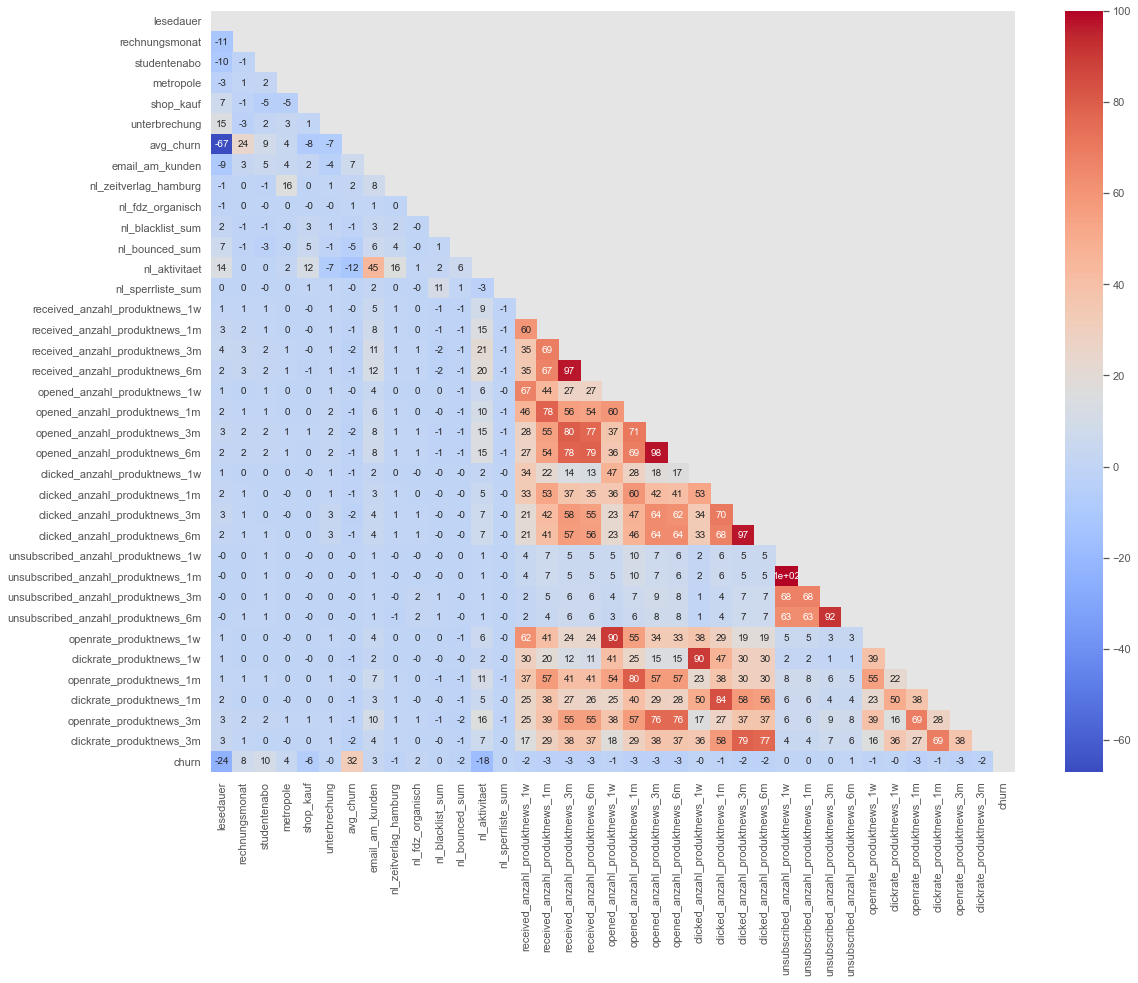

In [31]:
# correlation matrix and heatmap to establish corelation among exploratory variables
correlation(EDA_produktnews)

##### considering 80% as threshold following features exhibit strong correlation

1.  received_anzahl_produktnews_6m&emsp;&emsp;&emsp;&ensp;: received_anzahl_produktnews_6m  
2.  opened_anzahl_produktnews_3m&emsp;&emsp;&emsp;&ensp;: received_anzahl_produktnews_3m  
3.  opened_anzahl_produktnews_3m&emsp;&emsp;&emsp;&ensp;: received_anzahl_produktnews_6m 
4.  opened_anzahl_produktnews_6m&emsp;&emsp;&emsp;&ensp;: received_anzahl_produktnews_3m 
5.  opened_anzahl_produktnews_6m&emsp;&emsp;&emsp;&ensp;: received_anzahl_produktnews_6m 
6.  opened_anzahl_produktnews_6m&emsp;&emsp;&emsp;&ensp;: opened_anzahl_produktnews_3m 
7.  clicked_anzahl_produktnews_6m&emsp;&emsp;&emsp;&ensp;: clicked_anzahl_produktnews_3m  
8.  unsubscribed_anzahl_produktnews_1m&emsp;: unsubscribed_anzahl_produktnews_1m  
9.  unsubscribed_anzahl_produktnews_6m&emsp;: unsubscribed_anzahl_produktnews_3m
10. openrate_produktnews_1w&emsp;&emsp;&emsp;&emsp;&emsp;&ensp;&ensp;: opened_anzahl_produktnews_1w
11. clickrate_produktnews_1w&emsp;&emsp;&emsp;&emsp;&emsp;&ensp;&ensp;: clicked_anzahl_produktnews_1w
12. clickrate_produktnews_1m&emsp;&emsp;&emsp;&emsp;&emsp;&ensp;&ensp;: clicked_anzahl_produktnews_1m

we see from above correlation we consider only aggregate of 6 months period for EDA  
  
received_anzahl_produktnews_6m  
openedanzahl_produktnews_6m  
clicked_anzahl_produktnews_6m  
unsubscribed_anzahl_produktnews_6m  

#### looking for outliers

In [32]:
EDA_produktnews.received_anzahl_produktnews_6m.value_counts()

0     123781
1      19580
2       8721
3       2733
4        632
7        564
6        335
8        291
5        270
9         68
12         3
16         1
13         1
11         1
10         1
Name: received_anzahl_produktnews_6m, dtype: int64

In [33]:
EDA_produktnews.opened_anzahl_produktnews_6m.value_counts()

0     140721
1      10679
2       3507
3       1044
4        346
6        208
5        208
7        182
8         73
9         12
13         1
11         1
Name: opened_anzahl_produktnews_6m, dtype: int64

In [34]:
EDA_produktnews.clicked_anzahl_produktnews_6m.value_counts()

0    152968
1      3318
2       449
3       163
4        63
5        14
6         6
7         1
Name: clicked_anzahl_produktnews_6m, dtype: int64

In [114]:
EDA_produktnews.unsubscribed_anzahl_produktnews_6m.value_counts(1)

0    0.998994
1    0.001006
Name: unsubscribed_anzahl_produktnews_6m, dtype: float64

In [37]:
EDA_produktnews.openrate_produktnews_3m.value_counts()

0.00    141416
1.00     11485
0.50      2352
0.67       458
0.33       369
0.43        86
0.86        82
0.57        76
0.29        74
0.71        71
0.14        65
0.75        57
0.25        54
0.80        47
0.20        45
0.83        44
0.40        42
0.17        42
0.60        38
0.88        32
0.38        19
0.63        16
0.13         7
1.25         1
0.11         1
0.30         1
3.00         1
2.00         1
Name: openrate_produktnews_3m, dtype: int64

In [38]:
EDA_produktnews.clickrate_produktnews_3m.value_counts()

0.00    153313
1.00      1893
0.50       788
0.33       330
0.25       116
0.20        93
0.67        78
0.17        74
0.14        54
0.29        49
0.43        39
0.40        35
0.60        22
0.13        22
0.75        20
0.57        19
0.80        16
0.38         7
0.71         5
0.83         4
0.86         3
0.27         1
0.63         1
Name: clickrate_produktnews_3m, dtype: int64

there are possible outliers in the following columns :  

1. Number of unsubscribed in the last 6 months is very low around 0.001 %.  
   we don't need to alter the anything in produktnews category

2. received_anzahl_produktnews_6m  >>>>> assume above 9 as outliers  
   opened_anzahl_produktnews_6m  >>>>> assume above 9 as ouliers  
   clicked_anzahl_produktnews_6m >>>>> assume above 5 as outliers  
   openrate_produktnews_3m >>>>> assume rates above 1 as outlier or descrepency  
  
3. we see that there is descrepency in the recieved and opened numbers,  
   opened are more than recieved, we go with assumption that this would not have impact on our business case.



we create new columns without these outliers

In [83]:
EDA_produktnews_wo_outliers = EDA_produktnews.query('received_anzahl_produktnews_6m <= 9')

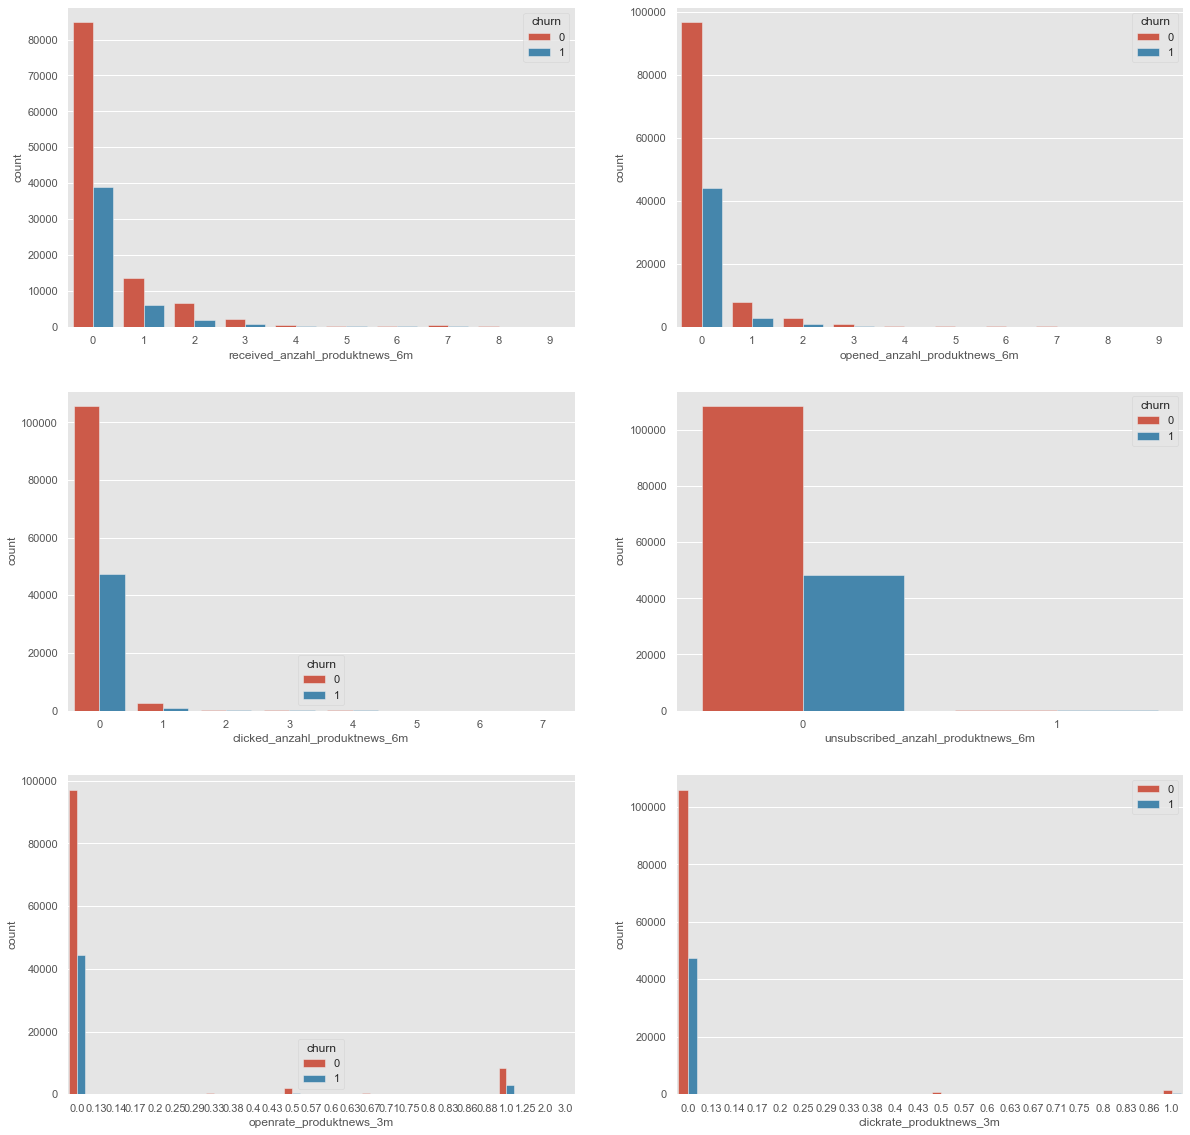

In [85]:
fig, axes = plt.subplots(ncols=2, nrows=3, figsize=(20, 20), sharey=False)

sns.countplot(data=EDA_produktnews_wo_outliers, x="received_anzahl_produktnews_6m", hue='churn', ax=axes[0][0])
sns.countplot(data=EDA_produktnews_wo_outliers, x="opened_anzahl_produktnews_6m", hue='churn', ax=axes[0][1])
sns.countplot(data=EDA_produktnews_wo_outliers, x="clicked_anzahl_produktnews_6m", hue='churn', ax=axes[1][0])
sns.countplot(data=EDA_produktnews_wo_outliers, x="unsubscribed_anzahl_produktnews_6m", hue='churn', ax=axes[1][1])
sns.countplot(data=EDA_produktnews_wo_outliers, x="openrate_produktnews_3m", hue='churn', ax=axes[2][0])
sns.countplot(data=EDA_produktnews_wo_outliers, x="clickrate_produktnews_3m", hue='churn', ax=axes[2][1])

In [93]:
# create list of categorical features
categorical_features = ['kanal','objekt_name','aboform_name','zahlung_rhythmus_name',
                     'zahlung_weg_name','land_iso_code','anrede','titel']


# create list of Numerical features grouped into week and monthly 
numerical_features = ['received_anzahl_produktnews_6m', 'opened_anzahl_produktnews_6m', 
                      'clicked_anzahl_produktnews_6m','unsubscribed_anzahl_produktnews_6m',
                      'openrate_produktnews_3m', 'clickrate_produktnews_3m']

Total Number of unique categories of kanal = 10


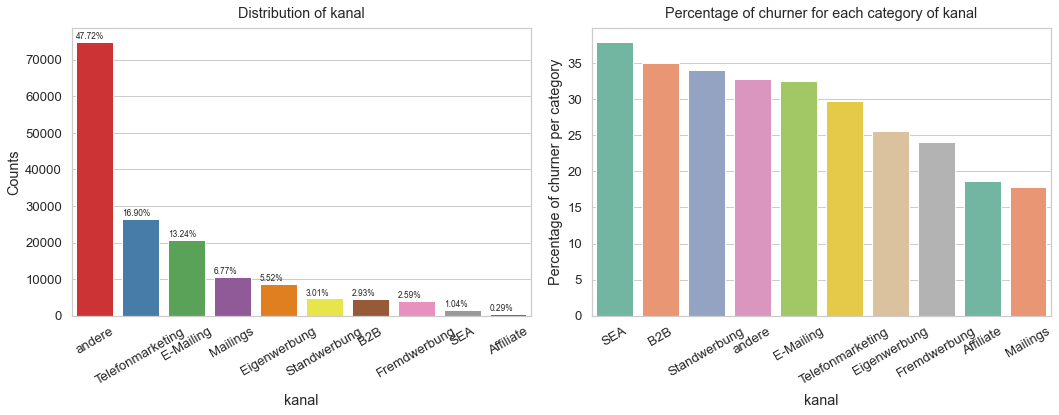



****************************************************************************************************
Total Number of unique categories of objekt_name = 3


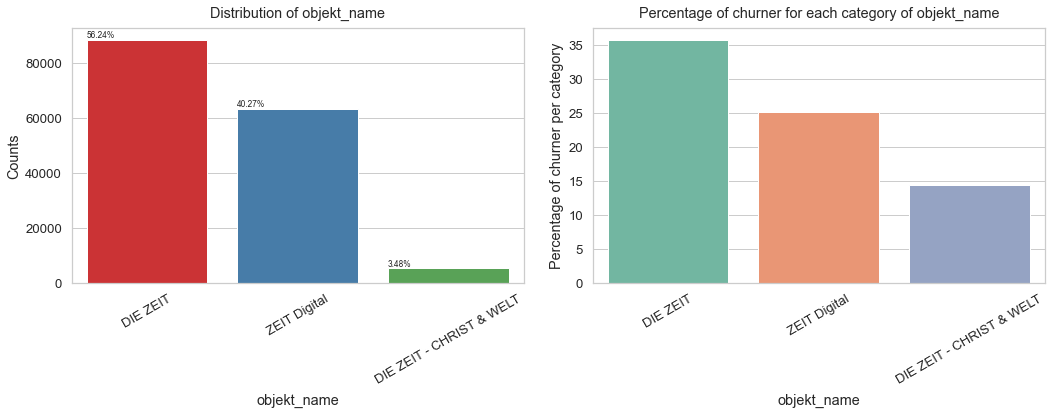



****************************************************************************************************
Total Number of unique categories of aboform_name = 5


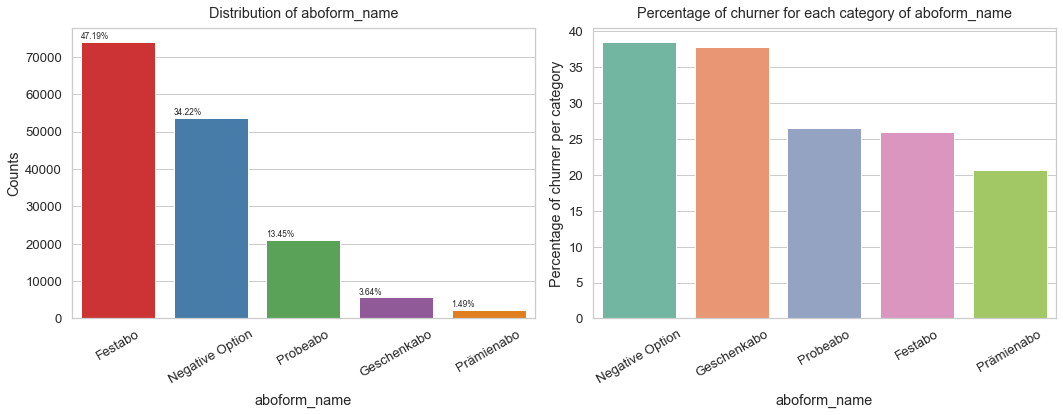



****************************************************************************************************
Total Number of unique categories of zahlung_rhythmus_name = 6


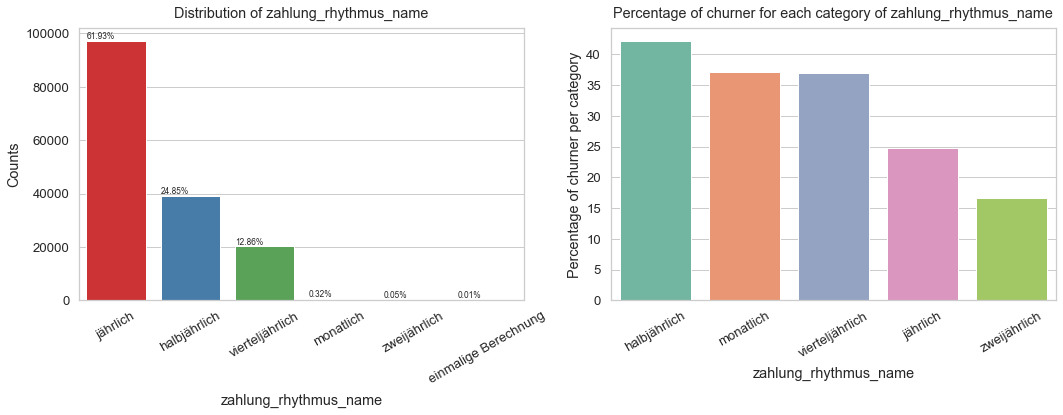



****************************************************************************************************
Total Number of unique categories of zahlung_weg_name = 4


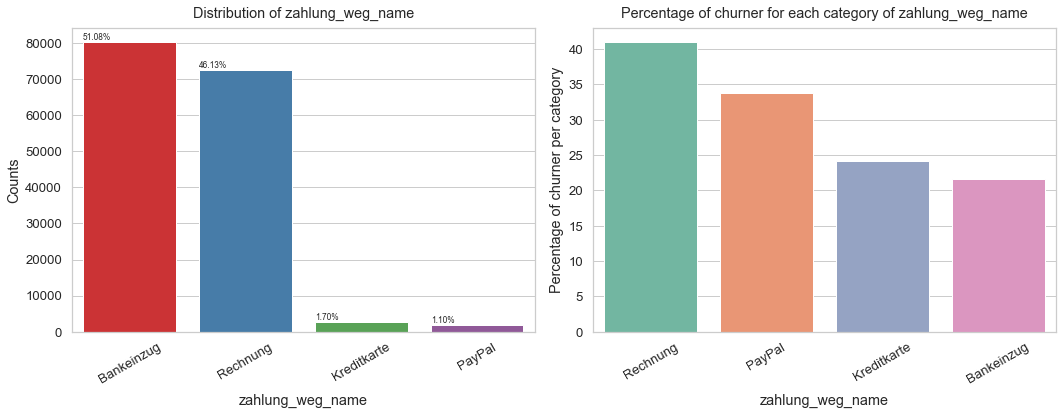



****************************************************************************************************
Total Number of unique categories of land_iso_code = 4


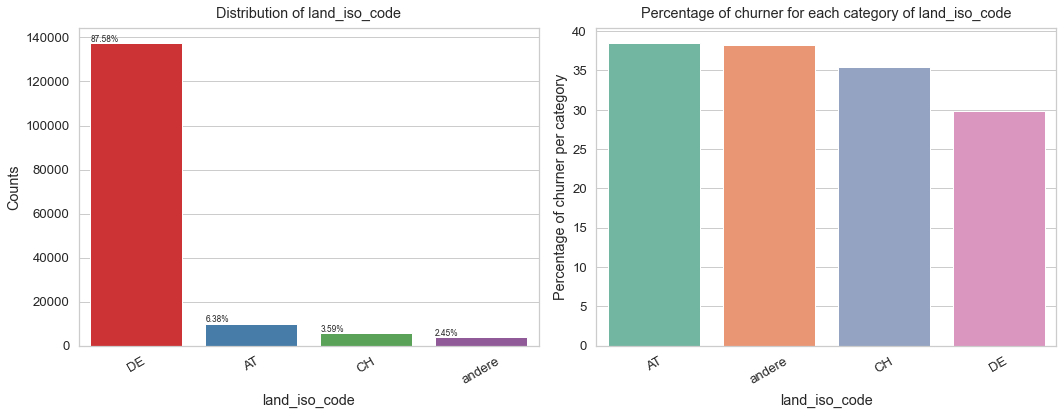



****************************************************************************************************
Total Number of unique categories of anrede = 4


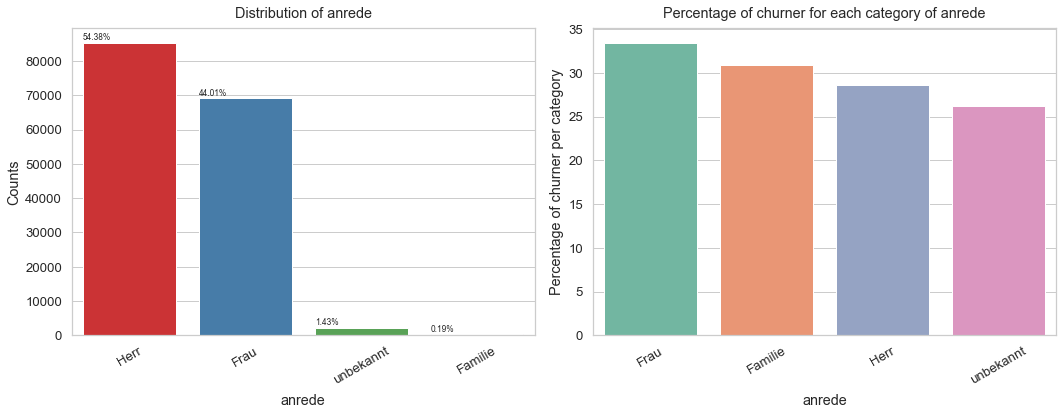



****************************************************************************************************
Total Number of unique categories of titel = 3


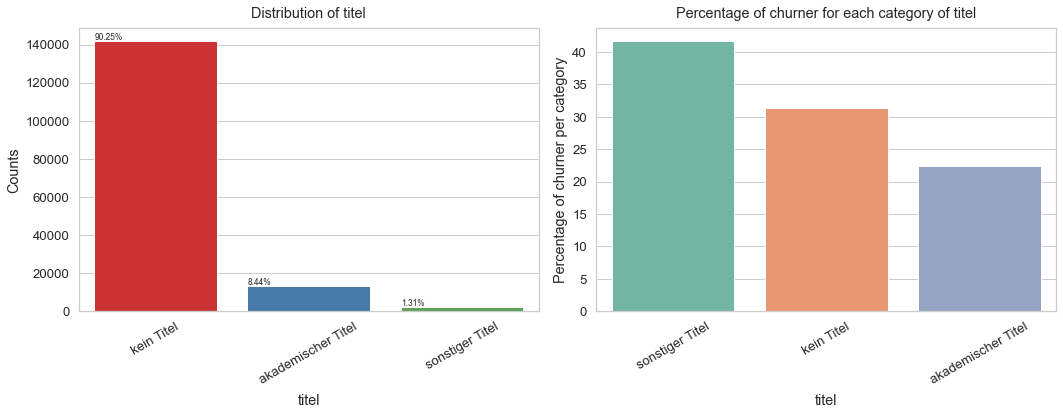



****************************************************************************************************


In [91]:
# plotting the categorical variable distrubution and churnrate
for feature in categorical_features:
    plot_categorical_variables_bar(EDA_produktnews_wo_outliers, feature, 30)  

We can have some recommendation looking at about distribution  

1. People with yearly payment, unsubscribe less
2. people with bank direct deduct, unsubscibe less

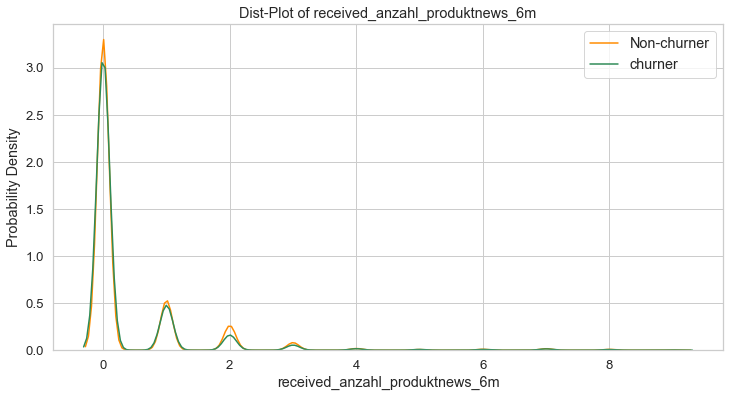

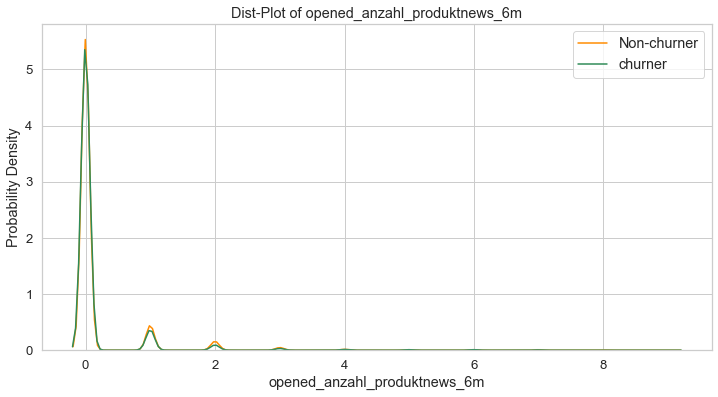

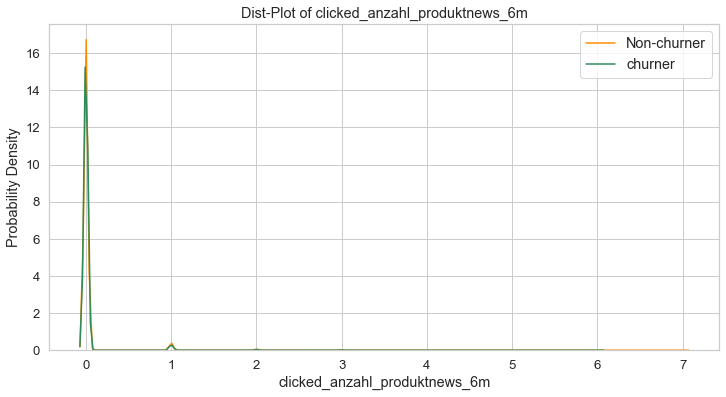

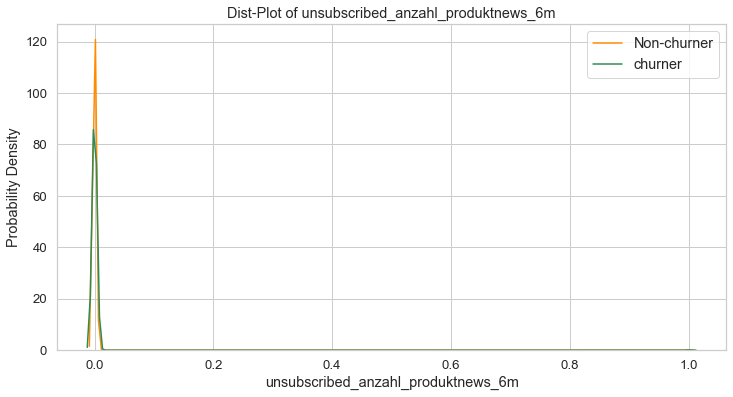

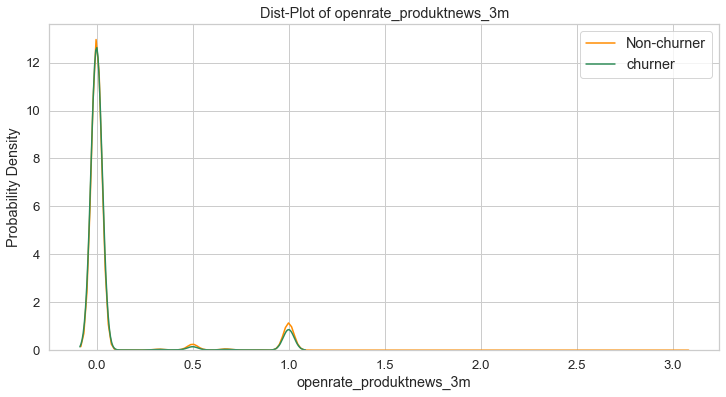

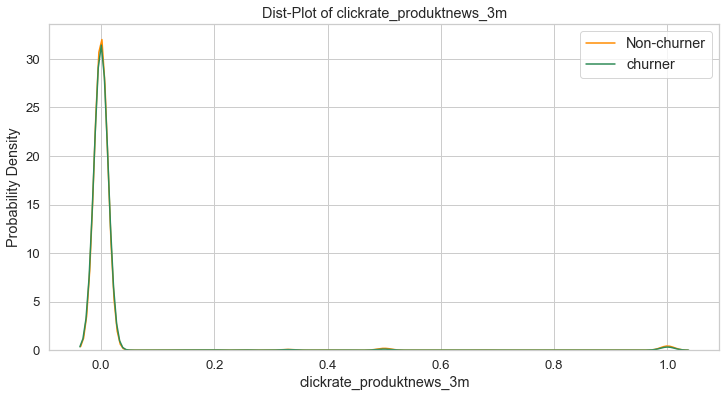

In [95]:
# plotting the numerical variable dstribution vs churn 
for feature in numerical_features:
    plot_numerical_variables(EDA_produktnews_wo_outliers, feature, plots=['distplot'])  

##### *Hamburg newsletter dataset and initial analysis*  

  
 
hamburg newsletter - Elbvertiefung – Der tägliche Newsletter für Hamburg  

Know everyday what is important in Hamburg  
hamburg Elbvertiefung is the new daily ZEIT newsletter for Hamburg

In [96]:
# creating hamburg newsletter dataframe with important variables that could influence the target value

# abonnement status variable alread stored
# data_abo_status 

# Initial 21 columns which contains demographic information already stored
# data_demo = df.iloc[:,0:21]

# columns with variables related to hamburg newsletter
data_hamburg = df.iloc[:,121:143]

# target variable already stored
#data_target = df['churn']

# combining all the splits to create new producktnews dataframe
EDA_hamburg = pd.concat([data_demo, data_abo_status, data_hamburg, data_target], axis=1)

In [97]:
# overview of new dataframe
EDA_hamburg.head()

,liefer_beginn_evt,kanal,objekt_name,aboform_name,zahlung_rhythmus_name,lesedauer,rechnungsmonat,zahlung_weg_name,studentenabo,plz_1,plz_2,plz_3,ort,metropole,land_iso_code,shop_kauf,unterbrechung,anrede,titel,avg_churn,email_am_kunden,nl_zeitverlag_hamburg,nl_fdz_organisch,nl_blacklist_sum,nl_bounced_sum,nl_aktivitaet,nl_registrierung_min,nl_sperrliste_sum,received_anzahl_hamburg_1w,received_anzahl_hamburg_1m,received_anzahl_hamburg_3m,received_anzahl_hamburg_6m,opened_anzahl_hamburg_1w,opened_anzahl_hamburg_1m,opened_anzahl_hamburg_3m,openedanzahl_hamburg_6m,clicked_anzahl_hamburg_1w,clicked_anzahl_hamburg_1m,clicked_anzahl_hamburg_3m,clicked_anzahl_hamburg_6m,unsubscribed_anzahl_hamburg_1w,unsubscribed_anzahl_hamburg_1m,unsubscribed_anzahl_hamburg_3m,unsubscribed_anzahl_hamburg_6m,openrate_hamburg_1w,clickrate_hamburg_1w,openrate_hamburg_1m,clickrate_hamburg_1m,openrate_hamburg_3m,clickrate_hamburg_3m,churn
0,2013-10-02,andere,ZEIT Digital,Probeabo,jährlich,68,0,Bankeinzug,0,6,64,647,Erbach,0,DE,4,0,Frau,akademischer Titel,0.133879,1.0,0,0,0,1,14,2005-09-30 00:00:00,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.00,0.0,0
1,2013-10-17,andere,ZEIT Digital,Festabo,jährlich,72,0,Bankeinzug,0,5,55,551,Mainz,0,DE,0,0,Herr,kein Titel,0.172959,1.0,0,0,0,0,14,2013-10-11 16:36:26,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.00,0.0,0
2,2013-09-12,andere,ZEIT Digital,Festabo,vierteljährlich,70,0,Bankeinzug,0,xx,xx,xx,London,0,andere,0,0,Frau,kein Titel,0.309526,1.0,0,0,0,0,14,2013-08-07 21:28:19,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.00,0.0,0
3,2013-11-14,andere,ZEIT Digital,Probeabo,jährlich,75,0,Bankeinzug,0,0,01,019,Großnaundorf,0,DE,0,0,Herr,kein Titel,0.127118,1.0,0,0,0,0,16,2013-10-14 18:36:26,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.00,0.0,0
4,2013-11-14,andere,ZEIT Digital,Probeabo,jährlich,78,0,Rechnung,0,2,23,238,Schiphorst,0,DE,0,0,Herr,kein Titel,0.114840,1.0,2,0,0,0,18,2013-10-13 14:53:34,0,6,21,70,124,6,21,66,118,0,0,0,0,0,0,0,0,1.0,0.0,1.0,0.0,0.94,0.0,0


In [100]:
# rename one of the column
EDA_hamburg.rename(columns = {'openedanzahl_hamburg_6m' : 'opened_anzahl_hamburg_6m'}, inplace=True)

In [101]:
# checking the deímension of the dataframe
EDA_hamburg.shape

(156982, 51)

In [102]:
# check the basic information for datatypes
EDA_hamburg.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 156982 entries, 0 to 156981
Data columns (total 51 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   liefer_beginn_evt               156982 non-null  object 
 1   kanal                           156982 non-null  object 
 2   objekt_name                     156982 non-null  object 
 3   aboform_name                    156982 non-null  object 
 4   zahlung_rhythmus_name           156982 non-null  object 
 5   lesedauer                       156982 non-null  int64  
 6   rechnungsmonat                  156982 non-null  int64  
 7   zahlung_weg_name                156982 non-null  object 
 8   studentenabo                    156982 non-null  int64  
 9   plz_1                           156982 non-null  object 
 10  plz_2                           156982 non-null  object 
 11  plz_3                           156982 non-null  object 
 12  ort             

In [103]:
# pivote table for different ZEIT articles
pd.pivot_table(EDA_hamburg, columns='objekt_name')

objekt_name,DIE ZEIT,DIE ZEIT - CHRIST & WELT,ZEIT Digital
avg_churn,0.318427,0.254802,0.313628
churn,0.357382,0.144085,0.251811
clicked_anzahl_hamburg_1m,0.051339,0.004206,0.091920
clicked_anzahl_hamburg_1w,0.014293,0.001280,0.023221
clicked_anzahl_hamburg_3m,0.141820,0.009691,0.261350
clicked_anzahl_hamburg_6m,0.266504,0.017553,0.494084
clickrate_hamburg_1m,0.004851,0.000658,0.007828
clickrate_hamburg_1w,0.003610,0.000272,0.005809
clickrate_hamburg_3m,0.006096,0.000975,0.009369
email_am_kunden,0.875712,0.740903,0.993530


##### Exploratory data analysis Hamburg newsletter dataset

In [104]:
# missing values in each column
missing_values_table(EDA_hamburg)

The selected dataframe has 51 columns.
There are 0 columns that have missing values.


,Missing Values,% of Total Values


In [105]:
# descriptive statistics 
EDA_hamburg.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
lesedauer,156982.0,31.786581,21.480402,0.000000,13.000000,26.000000,46.00000,88.000000
rechnungsmonat,156982.0,0.098827,0.298430,0.000000,0.000000,0.000000,0.00000,1.000000
studentenabo,156982.0,0.105254,0.306882,0.000000,0.000000,0.000000,0.00000,1.000000
metropole,156982.0,0.289944,0.453738,0.000000,0.000000,0.000000,1.00000,1.000000
shop_kauf,156982.0,0.446268,2.144259,0.000000,0.000000,0.000000,0.00000,152.000000
unterbrechung,156982.0,0.096591,0.295401,0.000000,0.000000,0.000000,0.00000,1.000000
avg_churn,156982.0,0.314278,0.148128,0.101208,0.184402,0.291863,0.40736,0.702078
email_am_kunden,156982.0,0.918462,0.273660,0.000000,1.000000,1.000000,1.00000,1.000000
nl_zeitverlag_hamburg,156982.0,0.115587,0.449186,0.000000,0.000000,0.000000,0.00000,2.000000
nl_fdz_organisch,156982.0,0.000401,0.020029,0.000000,0.000000,0.000000,0.00000,1.000000


In [106]:
# table of missing, duplicates and unique values along with datatype information
meta(EDA_hamburg)

varname,liefer_beginn_evt,clicked_anzahl_hamburg_3m,received_anzahl_hamburg_1w,received_anzahl_hamburg_1m,received_anzahl_hamburg_3m,received_anzahl_hamburg_6m,opened_anzahl_hamburg_1w,opened_anzahl_hamburg_1m,opened_anzahl_hamburg_3m,opened_anzahl_hamburg_6m,clicked_anzahl_hamburg_1w,clicked_anzahl_hamburg_1m,clicked_anzahl_hamburg_6m,nl_registrierung_min,unsubscribed_anzahl_hamburg_1w,unsubscribed_anzahl_hamburg_1m,unsubscribed_anzahl_hamburg_3m,unsubscribed_anzahl_hamburg_6m,openrate_hamburg_1w,clickrate_hamburg_1w,openrate_hamburg_1m,clickrate_hamburg_1m,openrate_hamburg_3m,clickrate_hamburg_3m,nl_sperrliste_sum,nl_aktivitaet,kanal,ort,objekt_name,aboform_name,zahlung_rhythmus_name,lesedauer,rechnungsmonat,zahlung_weg_name,studentenabo,plz_1,plz_2,plz_3,metropole,nl_bounced_sum,land_iso_code,shop_kauf,unterbrechung,anrede,titel,avg_churn,email_am_kunden,nl_zeitverlag_hamburg,nl_fdz_organisch,nl_blacklist_sum,churn
nulls,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
percent,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
dtype,object,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,object,int64,int64,int64,int64,float64,float64,float64,float64,float64,float64,int64,int64,object,object,object,object,object,int64,int64,object,int64,object,object,object,int64,int64,object,int64,int64,object,object,float64,float64,int64,int64,int64,int64
dup,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True
nuniques,406,69,9,30,73,126,18,35,76,131,10,29,116,118561,2,2,2,2,47,30,122,90,113,101,53,39,10,11424,3,5,6,89,2,4,2,11,97,697,2,16,4,63,2,4,3,176,2,3,2,21,2


,lesedauer,rechnungsmonat,studentenabo,metropole,shop_kauf,unterbrechung,avg_churn,email_am_kunden,nl_zeitverlag_hamburg,nl_fdz_organisch,nl_blacklist_sum,nl_bounced_sum,nl_aktivitaet,nl_sperrliste_sum,received_anzahl_hamburg_1w,received_anzahl_hamburg_1m,received_anzahl_hamburg_3m,received_anzahl_hamburg_6m,opened_anzahl_hamburg_1w,opened_anzahl_hamburg_1m,opened_anzahl_hamburg_3m,opened_anzahl_hamburg_6m,clicked_anzahl_hamburg_1w,clicked_anzahl_hamburg_1m,clicked_anzahl_hamburg_3m,clicked_anzahl_hamburg_6m,unsubscribed_anzahl_hamburg_1w,unsubscribed_anzahl_hamburg_1m,unsubscribed_anzahl_hamburg_3m,unsubscribed_anzahl_hamburg_6m,openrate_hamburg_1w,clickrate_hamburg_1w,openrate_hamburg_1m,clickrate_hamburg_1m,openrate_hamburg_3m,clickrate_hamburg_3m,churn
lesedauer,1.00,-0.11,-0.10,-0.03,0.07,0.15,-0.67,-0.09,-0.01,-0.01,0.02,0.07,0.14,0.00,-0.02,-0.02,-0.02,-0.02,-0.00,-0.00,-0.00,-0.00,0.00,-0.00,-0.00,-0.00,-0.00,-0.00,-0.01,-0.02,-0.01,-0.00,-0.00,-0.01,-0.00,-0.01,-0.24
rechnungsmonat,-0.11,1.00,-0.01,0.01,-0.01,-0.03,0.24,0.03,0.00,0.00,-0.01,-0.01,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,-0.00,0.00,0.00,0.08
studentenabo,-0.10,-0.01,1.00,0.02,-0.05,0.02,0.09,0.05,-0.01,-0.00,-0.01,-0.03,0.00,-0.00,-0.01,-0.01,-0.01,-0.01,-0.02,-0.02,-0.02,-0.02,-0.01,-0.01,-0.01,-0.01,0.00,0.00,-0.00,0.01,-0.02,-0.01,-0.02,-0.01,-0.02,-0.01,0.10
metropole,-0.03,0.01,0.02,1.00,-0.05,0.03,0.04,0.04,0.16,0.00,-0.00,-0.00,0.02,0.00,0.15,0.15,0.15,0.15,0.12,0.13,0.13,0.13,0.07,0.09,0.09,0.09,0.01,0.01,0.02,0.02,0.12,0.07,0.13,0.09,0.13,0.09,0.04
shop_kauf,0.07,-0.01,-0.05,-0.05,1.00,0.01,-0.08,0.02,0.00,-0.00,0.03,0.05,0.12,0.01,0.00,0.01,0.00,0.00,0.01,0.02,0.02,0.02,0.01,0.02,0.01,0.02,-0.00,-0.00,-0.00,-0.00,0.01,0.01,0.02,0.01,0.02,0.01,-0.06
unterbrechung,0.15,-0.03,0.02,0.03,0.01,1.00,-0.07,-0.04,0.01,-0.00,0.01,-0.01,-0.07,0.01,0.00,0.00,0.00,0.00,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,-0.00
avg_churn,-0.67,0.24,0.09,0.04,-0.08,-0.07,1.00,0.07,0.02,0.01,-0.01,-0.05,-0.12,-0.00,0.02,0.02,0.02,0.02,0.01,0.01,0.01,0.01,0.00,0.00,0.00,0.00,0.01,0.01,0.01,0.02,0.01,0.00,0.01,0.01,0.01,0.01,0.32
email_am_kunden,-0.09,0.03,0.05,0.04,0.02,-0.04,0.07,1.00,0.08,0.01,0.03,0.06,0.45,0.02,0.06,0.07,0.07,0.07,0.04,0.05,0.05,0.05,0.02,0.03,0.03,0.03,0.01,0.01,0.01,0.01,0.04,0.02,0.05,0.03,0.05,0.03,0.03
nl_zeitverlag_hamburg,-0.01,0.00,-0.01,0.16,0.00,0.01,0.02,0.08,1.00,0.00,0.02,0.04,0.16,0.00,0.89,0.91,0.92,0.92,0.61,0.64,0.66,0.66,0.33,0.37,0.40,0.41,0.04,0.04,0.07,0.10,0.62,0.34,0.65,0.41,0.66,0.46,-0.01
nl_fdz_organisch,-0.01,0.00,-0.00,0.00,-0.00,-0.00,0.01,0.01,0.00,1.00,-0.00,-0.00,0.01,-0.00,-0.00,-0.00,0.00,0.00,0.00,0.00,0.01,0.01,0.01,0.00,0.00,0.01,-0.00,-0.00,0.01,0.01,0.00,0.01,0.00,0.00,0.01,0.00,0.02


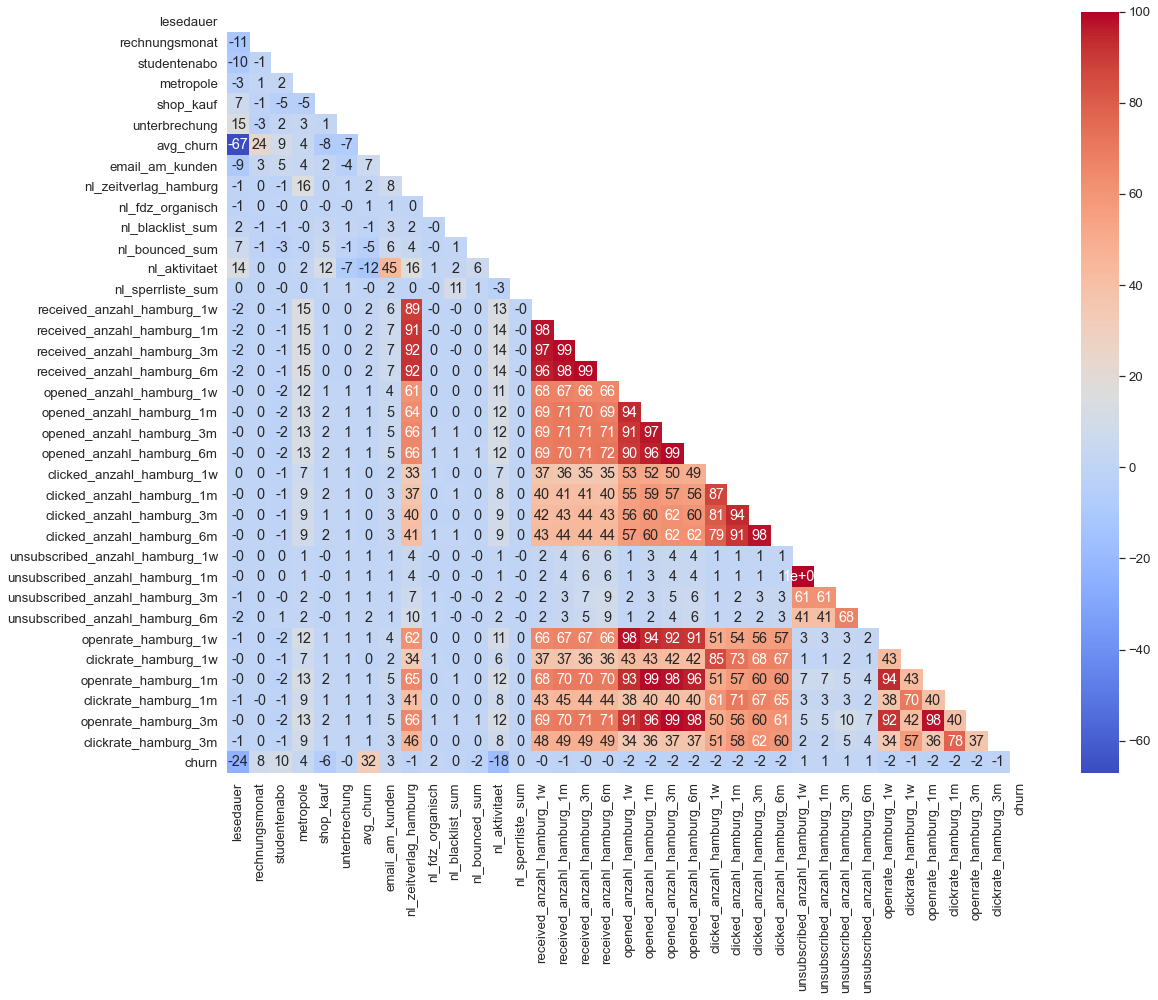

In [107]:
# correlation matrix and heatmap to establish corelation among exploratory variables
correlation(EDA_hamburg)

##### Correlates features from the matrix for Hamburg newsletter (corr >= 80)

1.  received_anzahl_hamburg_1m         : received_anzahl_hamburg_1w  
2.  received_anzahl_hamburg_3m         : received_anzahl_hamburg_1w   
3.  received_anzahl_hamburg_3m         : received_anzahl_hamburg_1m  
4.  received_anzahl_hamburg_6m         : received_anzahl_hamburg_1w  
5.  received_anzahl_hamburg_6m         : received_anzahl_hamburg_1m  
6.  received_anzahl_hamburg_6m         : received_anzahl_hamburg_3m  
7.  opened_anzahl_hamburg_1m           : opened_anzahl_hamburg_1w
8.  opened_anzahl_hamburg_3m           : opened_anzahl_hamburg_1w
9.  opened_anzahl_hamburg_3m           : opened_anzahl_hamburg_1m
10. opened_anzahl_hamburg_3m           : opened_anzahl_hamburg_1w
11. opened_anzahl_hamburg_6m           : opened_anzahl_hamburg_1w
12. opened_anzahl_hamburg_6m           : opened_anzahl_hamburg_1m
13. opened_anzahl_hamburg_6m           : opened_anzahl_hamburg_3m
14. clicked_anzahl_hamburg_1m          : clicked_anzahl_hamburg_1w
15. clicked_anzahl_hamburg_3m          : clicked_anzahl_hamburg_1w
16. clicked_anzahl_hamburg_3m          : clicked_anzahl_hamburg_1m
17. clicked_anzahl_hamburg_6m          : clicked_anzahl_hamburg_1w
18. clicked_anzahl_hamburg_6m          : clicked_anzahl_hamburg_1m
19. clicked_anzahl_hamburg_6m          : clicked_anzahl_hamburg_3m
20. unsubscribed_anzahl_hamburg_1m     : unsubscribed_anzahl_hamburg_1w
21. openrate_hamburg_1w                : opened_anzahl_hamburg_1w
22. openrate_hamburg_1w                : opened_anzahl_hamburg_1m
23. openrate_hamburg_1w                : opened_anzahl_hamburg_3m
24. openrate_hamburg_1w                : opened_anzahl_hamburg_6m
25. openrate_hamburg_1m                : opened_anzahl_hamburg_1w
26. openrate_hamburg_1m                : opened_anzahl_hamburg_1m
27. openrate_hamburg_1m                : opened_anzahl_hamburg_3m
28. openrate_hamburg_1m                : opened_anzahl_hamburg_6m
29. openrate_hamburg_1m                : openrate_hamburg_1w
30. openrate_hamburg_3m                : opened_anzahl_hamburg_1w
31. openrate_hamburg_3m                : opened_anzahl_hamburg_1m
32. openrate_hamburg_3m                : opened_anzahl_hamburg_3m
33. openrate_hamburg_3m                : opened_anzahl_hamburg_6m
34. openrate_hamburg_3m                : openrate_hamburg_1w
35. openrate_hamburg_3m                : openrate_hamburg_1m

we see from above correlation we consider only aggregate of 6 months period for EDA  
  
received_anzahl_hamburg_6m  
opened_anzahl_hamburg_6m 
clicked_anzahl_produktnews_6m  
unsubscribed_anzahl_produktnews_6m 

#### looking for outliers

In [109]:
EDA_hamburg.received_anzahl_hamburg_6m.value_counts()

0      149144
121      1638
122      1120
115       752
116       747
124       656
123       493
125       372
119       250
120       232
117       191
110       178
109       163
118       123
111       111
112       100
126        62
113        37
114        32
102        16
100        14
108        13
107        12
88         12
101        12
19         10
95         10
92          9
69          9
98          9
58          8
6           8
89          8
86          8
46          8
4           8
26          7
25          7
30          7
33          7
22          7
74          7
38          7
21          7
7           7
84          7
85          7
94          7
99          7
103         7
2           7
105         7
106         7
40          7
45          6
11          6
20          6
16          6
5           6
3           6
59          6
63          6
73          6
75          6
66          6
68          6
96          6
83          6
29          5
12          5
34          5
42    

In [110]:
EDA_hamburg.opened_anzahl_hamburg_6m.value_counts()

0      150195
1         480
2         281
3         229
4         173
6         160
5         141
121       132
115       122
7         119
120       109
119       103
116       103
10         99
9          89
8          89
117        89
112        88
12         85
114        83
122        83
113        80
13         77
111        73
11         72
107        70
18         68
118        65
109        63
17         62
14         61
16         61
108        60
110        60
15         59
20         56
23         53
104        52
22         49
21         48
124        48
123        47
25         46
105        45
24         44
19         44
101        43
30         43
48         42
29         42
39         41
102        41
27         41
100        41
98         41
26         40
28         39
106        39
42         38
33         38
77         37
53         37
97         37
35         37
44         36
58         36
103        36
32         36
31         36
92         36
38         35
34    

In [111]:
EDA_hamburg.clicked_anzahl_hamburg_6m.value_counts()

0      152010
1         937
2         618
3         416
4         327
5         275
6         237
7         212
8         171
9         165
10        133
11        120
12        111
13         98
14         79
15         75
16         70
19         70
17         59
18         54
20         44
24         35
23         35
21         34
25         33
26         33
22         32
27         32
28         30
29         25
31         20
35         19
32         19
36         19
30         15
34         14
42         13
33         12
43         12
37         11
48         10
44         10
40          9
50          8
45          7
66          7
51          7
58          7
46          7
52          7
69          7
41          7
38          7
120         6
61          6
49          6
71          6
47          5
77          5
53          4
76          4
81          4
59          4
60          4
62          4
63          4
114         3
115         3
39          3
72          3
85          3
95    

In [113]:
EDA_hamburg.unsubscribed_anzahl_hamburg_6m.value_counts(1)

0    0.998127
1    0.001873
Name: unsubscribed_anzahl_hamburg_6m, dtype: float64

there are no possible outliers as hamburg newsletter is sent daily, the MAX value for 6 months  
is below the maximum possible 180 days.

1. Number of unsubscribed in the last 6 months is very low around 0.001 %.  
   we don't need to alter the anything in hamburg newsletter category
  
2. we see that there is descrepency in the recieved and opened numbers,  
   opened are more than recieved.  
   we can go with assumption that this would not have impact on our business case.

In [125]:
EDA_hamburg.query('received_anzahl_hamburg_6m >=1 & nl_zeitverlag_hamburg != 2').sort_values(
    "received_anzahl_hamburg_6m", ascending=False).head(50)

,liefer_beginn_evt,kanal,objekt_name,aboform_name,zahlung_rhythmus_name,lesedauer,rechnungsmonat,zahlung_weg_name,studentenabo,plz_1,plz_2,plz_3,ort,metropole,land_iso_code,shop_kauf,unterbrechung,anrede,titel,avg_churn,email_am_kunden,nl_zeitverlag_hamburg,nl_fdz_organisch,nl_blacklist_sum,nl_bounced_sum,nl_aktivitaet,nl_registrierung_min,nl_sperrliste_sum,received_anzahl_hamburg_1w,received_anzahl_hamburg_1m,received_anzahl_hamburg_3m,received_anzahl_hamburg_6m,opened_anzahl_hamburg_1w,opened_anzahl_hamburg_1m,opened_anzahl_hamburg_3m,opened_anzahl_hamburg_6m,clicked_anzahl_hamburg_1w,clicked_anzahl_hamburg_1m,clicked_anzahl_hamburg_3m,clicked_anzahl_hamburg_6m,unsubscribed_anzahl_hamburg_1w,unsubscribed_anzahl_hamburg_1m,unsubscribed_anzahl_hamburg_3m,unsubscribed_anzahl_hamburg_6m,openrate_hamburg_1w,clickrate_hamburg_1w,openrate_hamburg_1m,clickrate_hamburg_1m,openrate_hamburg_3m,clickrate_hamburg_3m,churn
13312,2014-11-06,Mailings,DIE ZEIT,Probeabo,jährlich,61,0,Bankeinzug,0,2,22,225,Hamburg,1,DE,0,0,Frau,kein Titel,0.192307,1.0,1,0,0,0,8,2010-03-10 07:44:29,0,5,22,61,126,0,3,27,67,0,1,3,12,0,0,0,0,0.00,0.00,0.14,0.33,0.44,0.11,0
80102,2017-06-01,andere,ZEIT Digital,Festabo,halbjährlich,30,1,Bankeinzug,0,2,20,201,Hamburg,1,DE,0,0,Herr,kein Titel,0.324652,1.0,1,0,0,0,11,2012-08-09 22:00:32,0,6,23,61,125,1,3,22,34,0,0,0,0,0,0,0,0,0.17,0.00,0.13,0.00,0.36,0.00,0
132833,2018-09-05,andere,ZEIT Digital,Festabo,jährlich,15,0,Rechnung,0,2,27,273,Rotenburg,0,DE,0,0,Herr,kein Titel,0.282485,1.0,1,0,0,0,9,2018-09-01 10:57:40,0,6,23,61,125,0,0,0,3,0,0,0,0,0,0,0,0,0.00,0.00,0.00,0.00,0.00,0.00,1
70369,2017-09-14,Telefonmarketing,ZEIT Digital,Festabo,vierteljährlich,27,0,Rechnung,0,2,22,228,Norderstedt,0,DE,1,0,Herr,kein Titel,0.318611,1.0,1,0,0,0,8,2017-09-06 14:16:09,0,5,21,61,125,0,3,5,14,0,0,0,1,0,0,0,0,0.00,0.00,0.14,0.00,0.08,0.00,1
114224,2018-12-18,andere,ZEIT Digital,Festabo,jährlich,11,0,Bankeinzug,0,2,21,212,Buchholz,0,DE,0,0,Herr,kein Titel,0.610627,1.0,1,0,0,0,4,2018-12-11 12:25:46,0,5,20,61,125,5,20,61,123,0,0,0,7,0,0,0,0,1.00,0.00,1.00,0.00,1.00,0.00,0
18984,2015-08-13,andere,ZEIT Digital,Festabo,jährlich,52,0,Bankeinzug,0,2,25,253,Elmshorn,0,DE,0,0,Herr,akademischer Titel,0.125643,1.0,1,0,0,0,9,2014-07-24 02:30:33,0,5,22,61,125,1,4,14,23,0,0,0,3,0,0,0,0,0.20,0.00,0.18,0.00,0.23,0.00,0
74365,2017-06-08,andere,ZEIT Digital,Festabo,vierteljährlich,30,0,Bankeinzug,0,2,20,202,Hamburg,1,DE,0,0,Herr,kein Titel,0.312500,1.0,1,0,0,0,8,2017-06-03 11:44:38,0,6,23,61,125,6,23,61,125,0,0,2,4,0,0,0,0,1.00,0.00,1.00,0.00,1.00,0.03,1
137856,2018-06-20,andere,ZEIT Digital,Festabo,jährlich,18,0,Bankeinzug,0,2,20,202,Hamburg,1,DE,0,0,Frau,kein Titel,0.198327,1.0,1,0,0,3,9,2010-02-02 00:00:00,0,5,21,61,125,5,21,61,124,0,4,18,36,0,0,0,0,1.00,0.00,1.00,0.19,1.00,0.30,0
148215,2018-12-13,andere,DIE ZEIT,Festabo,jährlich,12,1,Bankeinzug,1,2,23,235,Lübeck,0,DE,0,0,Frau,kein Titel,0.540978,1.0,1,0,0,0,5,2018-11-30 03:37:32,0,6,23,61,125,0,0,0,0,0,0,0,0,0,0,0,0,0.00,0.00,0.00,0.00,0.00,0.00,1
78611,2018-07-12,andere,DIE ZEIT,Festabo,jährlich,22,0,Rechnung,0,2,20,202,Hamburg,1,DE,0,0,Herr,kein Titel,0.309744,1.0,1,0,0,0,5,2011-05-09 13:57:16,0,5,22,70,125,0,0,1,1,0,0,1,1,0,0,0,0,0.00,0.00,0.00,0.00,0.01,1.00,0


In [126]:
EDA_hamburg.query('received_anzahl_hamburg_6m >=1 & nl_zeitverlag_hamburg != 2').count()

liefer_beginn_evt                 568
kanal                             568
objekt_name                       568
aboform_name                      568
zahlung_rhythmus_name             568
lesedauer                         568
rechnungsmonat                    568
zahlung_weg_name                  568
studentenabo                      568
plz_1                             568
plz_2                             568
plz_3                             568
ort                               568
metropole                         568
land_iso_code                     568
shop_kauf                         568
unterbrechung                     568
anrede                            568
titel                             568
avg_churn                         568
email_am_kunden                   568
nl_zeitverlag_hamburg             568
nl_fdz_organisch                  568
nl_blacklist_sum                  568
nl_bounced_sum                    568
nl_aktivitaet                     568
nl_registrie

568 people are not active but still recieve hamburg newsletter

#### create data subset for those who recieved atleast one hamburg newsletter

In [127]:
df_ham_abo = EDA_hamburg.query('received_anzahl_hamburg_6m >= 1')

In [128]:
df_ham_abo.shape

(7838, 51)

In [130]:
EDA_hamburg.nl_zeitverlag_hamburg.value_counts()

0    146650
2      7813
1      2519
Name: nl_zeitverlag_hamburg, dtype: int64

The variable 'nl_zeitverlag_hamburg' relates to subscribers to the hamburg - Newsletter.  

There 146k active subscribers but only 7k subscribers who received at least 1 newsletter i.t.l.6M which probably is a result of a bad Data Architecture cause of wrongly tuned APIs.  

Checking the lines and creating a subset of people who did not subscribe to the newsletter but received a newsletter:


In [137]:
df_wierd = EDA_hamburg.query('received_anzahl_hamburg_6m >= 1 & nl_zeitverlag_hamburg !=2').sort_values(
    "received_anzahl_hamburg_6m", ascending=False)

In [138]:
df_wierd.shape

(568, 51)

In [139]:
df_wierd.nl_zeitverlag_hamburg.value_counts()

1    559
0      9
Name: nl_zeitverlag_hamburg, dtype: int64

In [142]:
df_wierd.zahlung_weg_name.value_counts()

Bankeinzug     282
Rechnung       257
PayPal          20
Kreditkarte      9
Name: zahlung_weg_name, dtype: int64

In the subset df_weird we got 568  
subscribers who are either 0 = "not available" or 1 = "signed off"  
but received a newsletter in the last 6 months and are paying for this , this seems like an error. 

<AxesSubplot:xlabel='clickrate_hamburg_3m', ylabel='Count'>

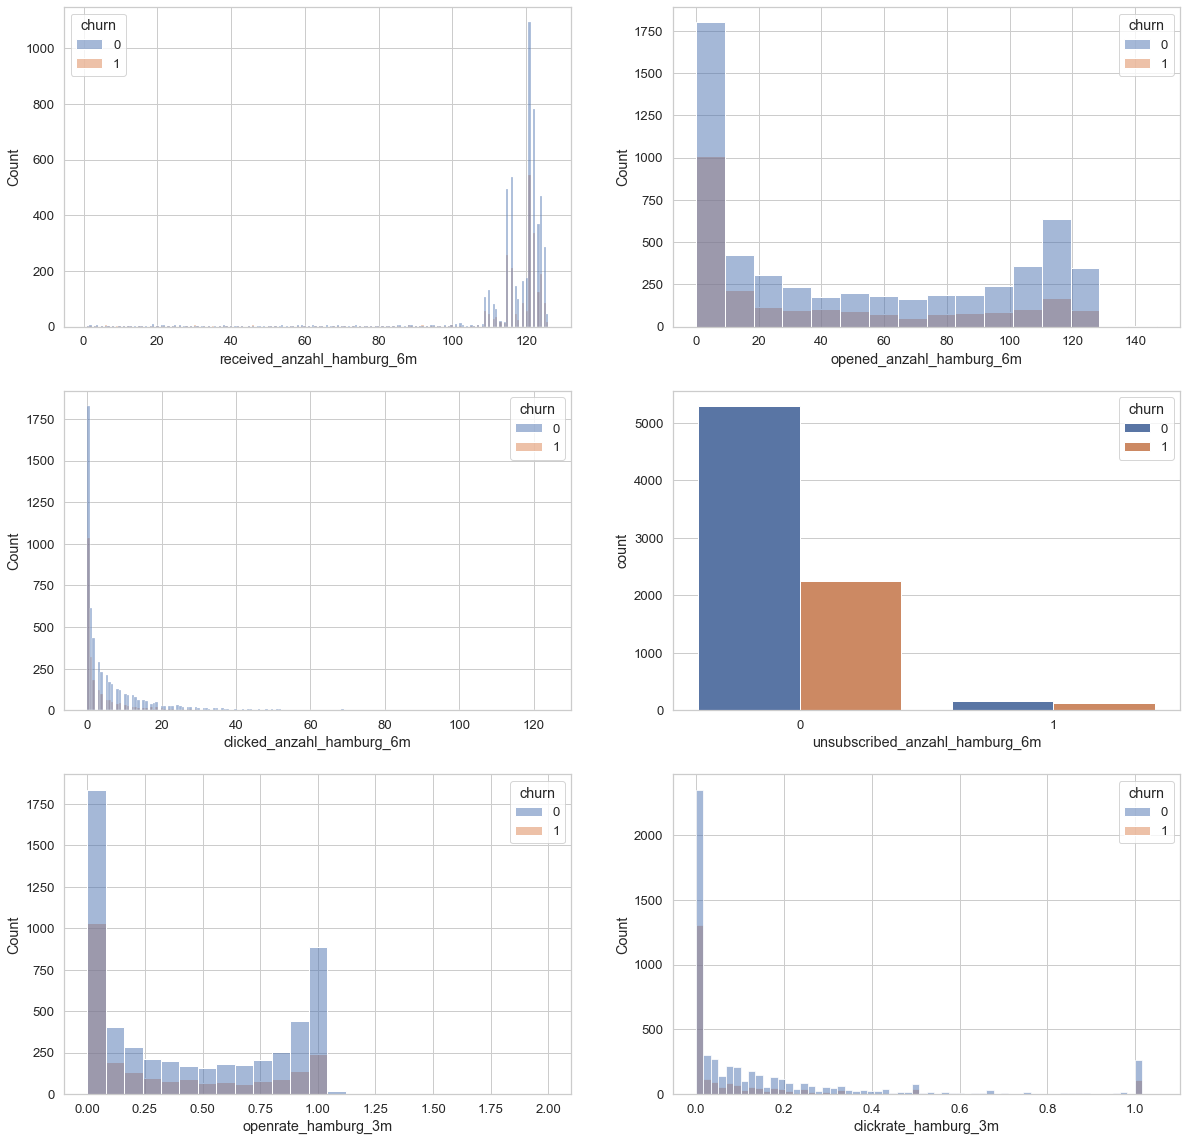

In [148]:
fig, axes = plt.subplots(ncols=2, nrows=3, figsize=(20, 20), sharey=False)

sns.histplot(data=df_ham_abo, x="received_anzahl_hamburg_6m", hue='churn', ax=axes[0][0])
sns.histplot(data=df_ham_abo, x="opened_anzahl_hamburg_6m", hue='churn', ax=axes[0][1])
sns.histplot(data=df_ham_abo, x="clicked_anzahl_hamburg_6m", hue='churn', ax=axes[1][0])
sns.countplot(data=df_ham_abo, x="unsubscribed_anzahl_hamburg_6m", hue='churn', ax=axes[1][1])
sns.histplot(data=df_ham_abo, x="openrate_hamburg_3m", hue='churn', ax=axes[2][0])
sns.histplot(data=df_ham_abo, x="clickrate_hamburg_3m", hue='churn', ax=axes[2][1])

In [155]:
df_ham_abo.query('received_anzahl_hamburg_6m > 100').received_anzahl_hamburg_6m.count()

7335

Hamburg - Newsletter stats:  
there are 7838 subscribers to the newsletter (received it at least 1 in the last 6m)  
93% of the subscribers received more than 100 newsletters in the last 6m  

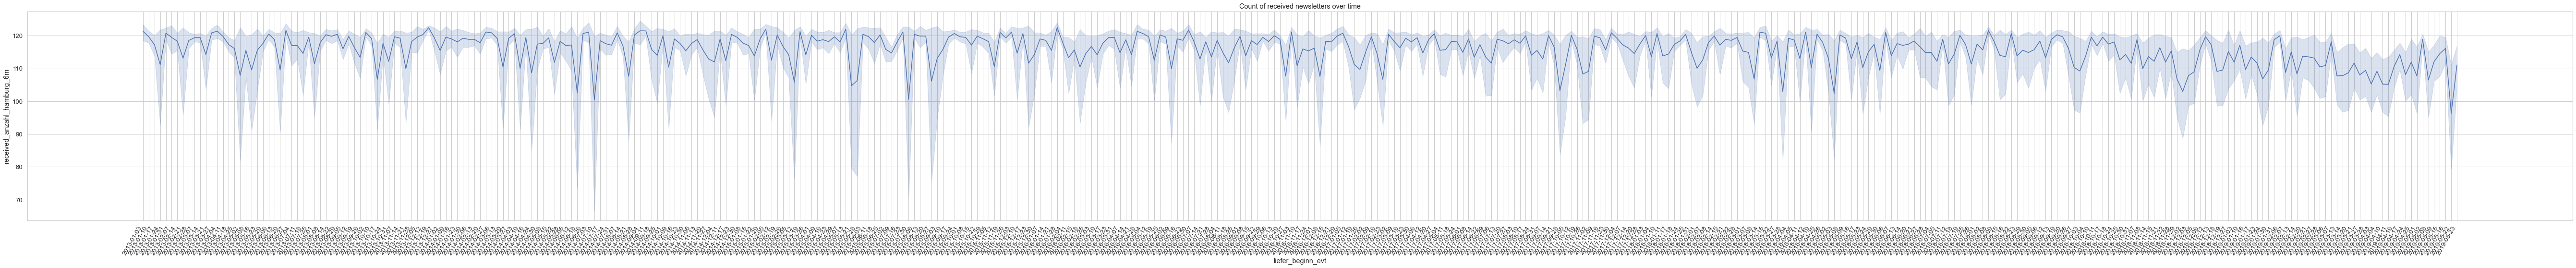

In [157]:
labels = sorted(list(set([i for i in df_ham_abo["liefer_beginn_evt"]])))

plt.figure(figsize=(95,8))
plt.title("Count of received newsletters over time")
t = sns.lineplot(data=df_ham_abo, x="liefer_beginn_evt", y="received_anzahl_hamburg_6m")
t.set_xticklabels(labels, rotation=60, ha="right");

In [163]:
# create list of Numerical features grouped into week and monthly 
numerical_features_ham = ['received_anzahl_hamburg_6m', 'opened_anzahl_hamburg_6m', 
                      'clicked_anzahl_hamburg_6m',
                      'openrate_hamburg_3m', 'clickrate_hamburg_3m']

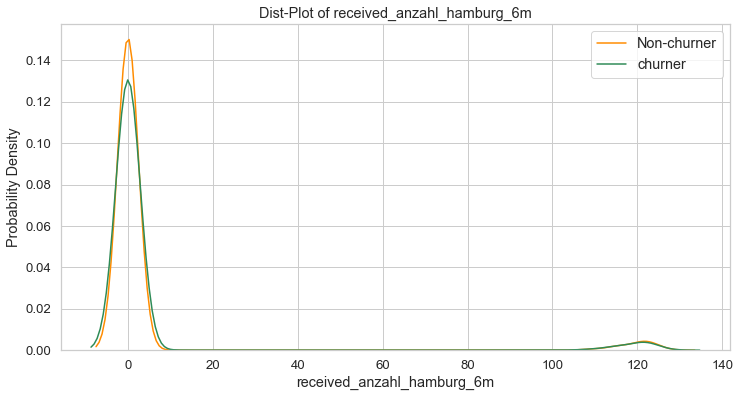

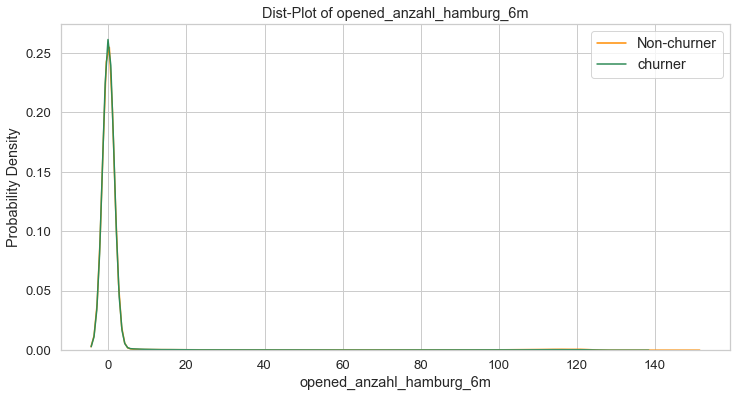

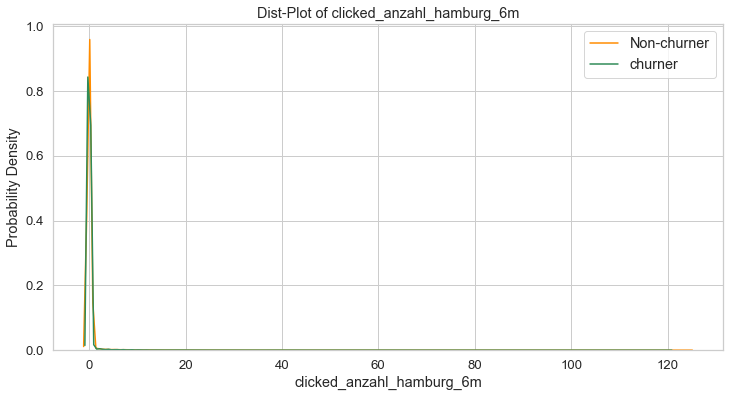

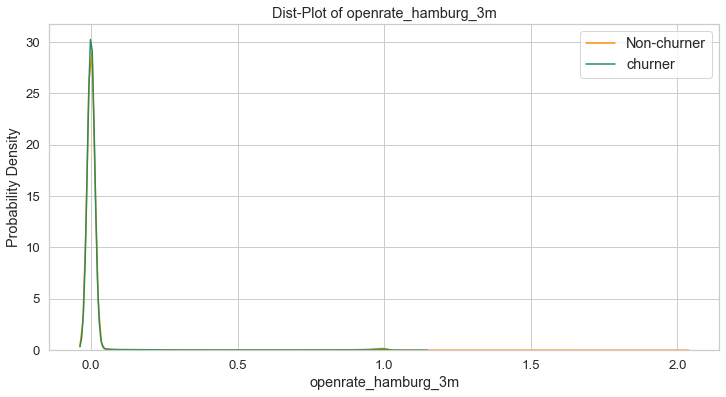

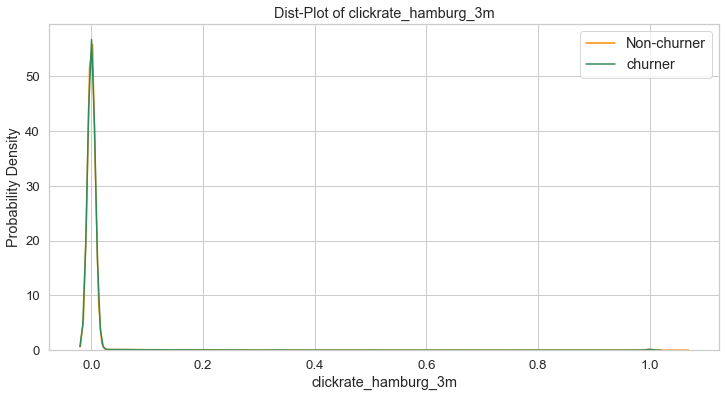

In [164]:
# plotting the numerical variable dstribution vs churn 
for feature in numerical_features_ham:
    plot_numerical_variables(EDA_hamburg, feature, plots=['distplot'])  